## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [2]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
net = Net()
net.cuda()
#net.to(device)
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=136, bias=True)
  (dropout1): Dropout(p=0.1)
  (dropout2): Dropout(p=0.2)
  (dropout3): Dropout(p=0.3)
  (dropout4): Dropout(p=0.4)
  (dropout5): Dropout(p=0.4)
  (dropout6): Dropout(p=0.4)
)


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [3]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])
# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [4]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [5]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [6]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                             root_dir='data/test/',
                                             transform=data_transform)



In [7]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Make sure the image is a FloatTensor, which the model expects.
3. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [8]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']
        # convert images to FloatTensors
        images = images.type(torch.cuda.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        output_pts = output_pts
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [9]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [10]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

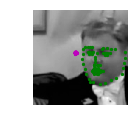

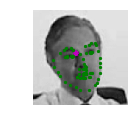

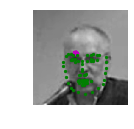

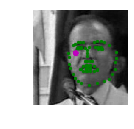

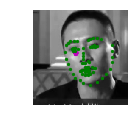

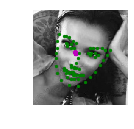

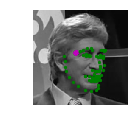

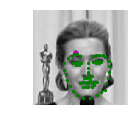

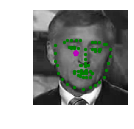

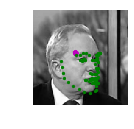

In [11]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's wrapper
        image = image.cpu().numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.cpu().numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [12]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion = nn.MSELoss()

optimizer = optim.Adam(net.parameters(), lr= 0.0004, betas=(0.8, 0.999))

## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [13]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.cuda.FloatTensor)
            images = images.type(torch.cuda.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to the running_loss, use .item()
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0

    print('Finished Training')


In [15]:
# train your network
n_epochs = 100 # start small, and increase when you've decided on your model structure and hyperparams

train_net(n_epochs)

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1, Batch: 10, Avg. Loss: 0.1732995703816414
Epoch: 1, Batch: 20, Avg. Loss: 0.2184798762202263
Epoch: 1, Batch: 30, Avg. Loss: 0.3524970538914204
Epoch: 1, Batch: 40, Avg. Loss: 0.2283776581287384
Epoch: 1, Batch: 50, Avg. Loss: 0.22267139554023743
Epoch: 1, Batch: 60, Avg. Loss: 0.1864928901195526
Epoch: 1, Batch: 70, Avg. Loss: 0.1914423018693924
Epoch: 1, Batch: 80, Avg. Loss: 0.17484157681465148
Epoch: 1, Batch: 90, Avg. Loss: 0.20466025918722153
Epoch: 1, Batch: 100, Avg. Loss: 0.17476906031370162
Epoch: 1, Batch: 110, Avg. Loss: 0.22192598581314088
Epoch: 1, Batch: 120, Avg. Loss: 0.18841148242354394
Epoch: 1, Batch: 130, Avg. Loss: 0.19817329794168473
Epoch: 1, Batch: 140, Avg. Loss: 0.2090647280216217
Epoch: 1, Batch: 150, Avg. Loss: 0.20551115721464158
Epoch: 1, Batch: 160, Avg. Loss: 0.2178836427628994
Epoch: 1, Batch: 170, Avg. Loss: 0.1886076346039772
Epoch: 1, Batch: 180, Avg. Loss: 0.2284668877720833
Epoch: 1, Batch: 190, Avg. Loss: 0.17885612994432448
Epoch: 1, Ba

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 2, Batch: 10, Avg. Loss: 0.18150632455945015
Epoch: 2, Batch: 20, Avg. Loss: 0.1914088822901249
Epoch: 2, Batch: 30, Avg. Loss: 0.16879256218671798
Epoch: 2, Batch: 40, Avg. Loss: 0.2010893777012825
Epoch: 2, Batch: 50, Avg. Loss: 0.1828139029443264
Epoch: 2, Batch: 60, Avg. Loss: 0.1762778326869011
Epoch: 2, Batch: 70, Avg. Loss: 0.35220461562275884
Epoch: 2, Batch: 80, Avg. Loss: 0.15478468537330628
Epoch: 2, Batch: 90, Avg. Loss: 0.21278810650110244
Epoch: 2, Batch: 100, Avg. Loss: 0.1779139146208763
Epoch: 2, Batch: 110, Avg. Loss: 0.17986013889312744
Epoch: 2, Batch: 120, Avg. Loss: 0.2151573047041893
Epoch: 2, Batch: 130, Avg. Loss: 0.16384634822607042
Epoch: 2, Batch: 140, Avg. Loss: 0.20017606467008592
Epoch: 2, Batch: 150, Avg. Loss: 0.16644449830055236
Epoch: 2, Batch: 160, Avg. Loss: 0.19082219526171684
Epoch: 2, Batch: 170, Avg. Loss: 0.18762352615594863
Epoch: 2, Batch: 180, Avg. Loss: 0.17729444578289985
Epoch: 2, Batch: 190, Avg. Loss: 0.2663037821650505
Epoch: 2,

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 3, Batch: 10, Avg. Loss: 0.1632535308599472
Epoch: 3, Batch: 20, Avg. Loss: 0.17501126304268838
Epoch: 3, Batch: 30, Avg. Loss: 0.14679362438619137
Epoch: 3, Batch: 40, Avg. Loss: 0.1489662580192089
Epoch: 3, Batch: 50, Avg. Loss: 0.16074594482779503
Epoch: 3, Batch: 60, Avg. Loss: 0.15586596503853797
Epoch: 3, Batch: 70, Avg. Loss: 0.17342033833265305
Epoch: 3, Batch: 80, Avg. Loss: 0.12498224452137947
Epoch: 3, Batch: 90, Avg. Loss: 0.2193177357316017
Epoch: 3, Batch: 100, Avg. Loss: 0.15309010893106462
Epoch: 3, Batch: 110, Avg. Loss: 0.13743513077497482
Epoch: 3, Batch: 120, Avg. Loss: 0.1354640543460846
Epoch: 3, Batch: 130, Avg. Loss: 0.14472523108124732
Epoch: 3, Batch: 140, Avg. Loss: 0.1268900990486145
Epoch: 3, Batch: 150, Avg. Loss: 0.15818292573094367
Epoch: 3, Batch: 160, Avg. Loss: 0.15088050961494445
Epoch: 3, Batch: 170, Avg. Loss: 0.14304917454719543
Epoch: 3, Batch: 180, Avg. Loss: 0.15195406675338746
Epoch: 3, Batch: 190, Avg. Loss: 0.15515322387218475
Epoch: 

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 4, Batch: 10, Avg. Loss: 0.13811752945184708
Epoch: 4, Batch: 20, Avg. Loss: 0.1485594753175974
Epoch: 4, Batch: 30, Avg. Loss: 0.10989373065531254
Epoch: 4, Batch: 40, Avg. Loss: 0.170418643951416
Epoch: 4, Batch: 50, Avg. Loss: 0.10465552508831025
Epoch: 4, Batch: 60, Avg. Loss: 0.2645174812525511
Epoch: 4, Batch: 70, Avg. Loss: 0.07279828228056431
Epoch: 4, Batch: 80, Avg. Loss: 0.08703014440834522
Epoch: 4, Batch: 90, Avg. Loss: 0.08903749287128448
Epoch: 4, Batch: 100, Avg. Loss: 0.07246287688612937
Epoch: 4, Batch: 110, Avg. Loss: 0.1060552317649126
Epoch: 4, Batch: 120, Avg. Loss: 0.10619499273598194
Epoch: 4, Batch: 130, Avg. Loss: 0.11046759486198425
Epoch: 4, Batch: 140, Avg. Loss: 0.11489001289010048
Epoch: 4, Batch: 150, Avg. Loss: 0.095468769967556
Epoch: 4, Batch: 160, Avg. Loss: 0.08926652036607266
Epoch: 4, Batch: 170, Avg. Loss: 0.08026734404265881
Epoch: 4, Batch: 180, Avg. Loss: 0.117635178565979
Epoch: 4, Batch: 190, Avg. Loss: 0.09296372234821319
Epoch: 4, B

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 5, Batch: 10, Avg. Loss: 0.07794630751013756
Epoch: 5, Batch: 20, Avg. Loss: 0.05810405872762203
Epoch: 5, Batch: 30, Avg. Loss: 0.08299948647618294
Epoch: 5, Batch: 40, Avg. Loss: 0.05530313029885292
Epoch: 5, Batch: 50, Avg. Loss: 0.08191115260124207
Epoch: 5, Batch: 60, Avg. Loss: 0.06790703535079956
Epoch: 5, Batch: 70, Avg. Loss: 0.07725322842597962
Epoch: 5, Batch: 80, Avg. Loss: 0.1990172252058983
Epoch: 5, Batch: 90, Avg. Loss: 0.09482429437339306
Epoch: 5, Batch: 100, Avg. Loss: 0.07615489475429058
Epoch: 5, Batch: 110, Avg. Loss: 0.136728660389781
Epoch: 5, Batch: 120, Avg. Loss: 0.07325522042810917
Epoch: 5, Batch: 130, Avg. Loss: 0.10640946626663209
Epoch: 5, Batch: 140, Avg. Loss: 0.09355588108301163
Epoch: 5, Batch: 150, Avg. Loss: 0.08058744072914123
Epoch: 5, Batch: 160, Avg. Loss: 0.09211046025156974
Epoch: 5, Batch: 170, Avg. Loss: 0.07744675427675247
Epoch: 5, Batch: 180, Avg. Loss: 0.0817616768181324
Epoch: 5, Batch: 190, Avg. Loss: 0.06825367398560048
Epoch:

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 6, Batch: 10, Avg. Loss: 0.04797567930072546
Epoch: 6, Batch: 20, Avg. Loss: 0.07343089655041694
Epoch: 6, Batch: 30, Avg. Loss: 0.07725179865956307
Epoch: 6, Batch: 40, Avg. Loss: 0.07606738246977329
Epoch: 6, Batch: 50, Avg. Loss: 0.09568526186048984
Epoch: 6, Batch: 60, Avg. Loss: 0.12148834839463234
Epoch: 6, Batch: 70, Avg. Loss: 0.055112401768565175
Epoch: 6, Batch: 80, Avg. Loss: 0.0673496002331376
Epoch: 6, Batch: 90, Avg. Loss: 0.09299665242433548
Epoch: 6, Batch: 100, Avg. Loss: 0.060744185373187064
Epoch: 6, Batch: 110, Avg. Loss: 0.0663500964641571
Epoch: 6, Batch: 120, Avg. Loss: 0.1082928128540516
Epoch: 6, Batch: 130, Avg. Loss: 0.079663160815835
Epoch: 6, Batch: 140, Avg. Loss: 0.0621451573446393
Epoch: 6, Batch: 150, Avg. Loss: 0.06916721165180206
Epoch: 6, Batch: 160, Avg. Loss: 0.07505185920745135
Epoch: 6, Batch: 170, Avg. Loss: 0.07456568479537964
Epoch: 6, Batch: 180, Avg. Loss: 0.08822665903717279
Epoch: 6, Batch: 190, Avg. Loss: 0.07041414175182581
Epoch:

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 7, Batch: 10, Avg. Loss: 0.054169364646077155
Epoch: 7, Batch: 20, Avg. Loss: 0.05405667684972286
Epoch: 7, Batch: 30, Avg. Loss: 0.05942994095385075
Epoch: 7, Batch: 40, Avg. Loss: 0.06536191683262586
Epoch: 7, Batch: 50, Avg. Loss: 0.04655583128333092
Epoch: 7, Batch: 60, Avg. Loss: 0.04572949409484863
Epoch: 7, Batch: 70, Avg. Loss: 0.06751536466181278
Epoch: 7, Batch: 80, Avg. Loss: 0.04549120124429464
Epoch: 7, Batch: 90, Avg. Loss: 0.06833004094660282
Epoch: 7, Batch: 100, Avg. Loss: 0.03799545187503099
Epoch: 7, Batch: 110, Avg. Loss: 0.048442224971950054
Epoch: 7, Batch: 120, Avg. Loss: 0.055280444025993344
Epoch: 7, Batch: 130, Avg. Loss: 0.06422585267573595
Epoch: 7, Batch: 140, Avg. Loss: 0.08376518432050943
Epoch: 7, Batch: 150, Avg. Loss: 0.04616030473262071
Epoch: 7, Batch: 160, Avg. Loss: 0.058780113235116005
Epoch: 7, Batch: 170, Avg. Loss: 0.041095399484038356
Epoch: 7, Batch: 180, Avg. Loss: 0.048664656840264796
Epoch: 7, Batch: 190, Avg. Loss: 0.04439423792064

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 8, Batch: 10, Avg. Loss: 0.050740768946707246
Epoch: 8, Batch: 20, Avg. Loss: 0.04099138397723436
Epoch: 8, Batch: 30, Avg. Loss: 0.03236558847129345
Epoch: 8, Batch: 40, Avg. Loss: 0.07629920020699502
Epoch: 8, Batch: 50, Avg. Loss: 0.04241220541298389
Epoch: 8, Batch: 60, Avg. Loss: 0.053214824944734576
Epoch: 8, Batch: 70, Avg. Loss: 0.045969078317284584
Epoch: 8, Batch: 80, Avg. Loss: 0.040915397554636
Epoch: 8, Batch: 90, Avg. Loss: 0.06938802935183049
Epoch: 8, Batch: 100, Avg. Loss: 0.05169814340770244
Epoch: 8, Batch: 110, Avg. Loss: 0.04853827878832817
Epoch: 8, Batch: 120, Avg. Loss: 0.06138304211199284
Epoch: 8, Batch: 130, Avg. Loss: 0.0545001357793808
Epoch: 8, Batch: 140, Avg. Loss: 0.05060570109635591
Epoch: 8, Batch: 150, Avg. Loss: 0.03961156383156776
Epoch: 8, Batch: 160, Avg. Loss: 0.06498075034469367
Epoch: 8, Batch: 170, Avg. Loss: 0.20678892657160758
Epoch: 8, Batch: 180, Avg. Loss: 0.054693573340773585
Epoch: 8, Batch: 190, Avg. Loss: 0.06568054147064686
E

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 9, Batch: 10, Avg. Loss: 0.058681027591228486
Epoch: 9, Batch: 20, Avg. Loss: 0.04198828898370266
Epoch: 9, Batch: 30, Avg. Loss: 0.13602062948048116
Epoch: 9, Batch: 40, Avg. Loss: 0.05813225731253624
Epoch: 9, Batch: 50, Avg. Loss: 0.07171971220523118
Epoch: 9, Batch: 60, Avg. Loss: 0.059183243475854394
Epoch: 9, Batch: 70, Avg. Loss: 0.03697908744215965
Epoch: 9, Batch: 80, Avg. Loss: 0.042712189443409446
Epoch: 9, Batch: 90, Avg. Loss: 0.049967150576412676
Epoch: 9, Batch: 100, Avg. Loss: 0.05955305751413107
Epoch: 9, Batch: 110, Avg. Loss: 0.04039708059281111
Epoch: 9, Batch: 120, Avg. Loss: 0.04879500325769186
Epoch: 9, Batch: 130, Avg. Loss: 0.05345447007566691
Epoch: 9, Batch: 140, Avg. Loss: 0.04178101811558008
Epoch: 9, Batch: 150, Avg. Loss: 0.08165401760488748
Epoch: 9, Batch: 160, Avg. Loss: 0.05752342566847801
Epoch: 9, Batch: 170, Avg. Loss: 0.06708951070904731
Epoch: 9, Batch: 180, Avg. Loss: 0.051863588951528074
Epoch: 9, Batch: 190, Avg. Loss: 0.050120675750076

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 10, Batch: 10, Avg. Loss: 0.04375692773610353
Epoch: 10, Batch: 20, Avg. Loss: 0.056455168128013614
Epoch: 10, Batch: 30, Avg. Loss: 0.06284007057547569
Epoch: 10, Batch: 40, Avg. Loss: 0.0636718850582838
Epoch: 10, Batch: 50, Avg. Loss: 0.04776556845754385
Epoch: 10, Batch: 60, Avg. Loss: 0.05481869578361511
Epoch: 10, Batch: 70, Avg. Loss: 0.07609058897942304
Epoch: 10, Batch: 80, Avg. Loss: 0.05791182331740856
Epoch: 10, Batch: 90, Avg. Loss: 0.05059619508683681
Epoch: 10, Batch: 100, Avg. Loss: 0.04956402871757746
Epoch: 10, Batch: 110, Avg. Loss: 0.03562656175345182
Epoch: 10, Batch: 120, Avg. Loss: 0.06163987684994936
Epoch: 10, Batch: 130, Avg. Loss: 0.036952893063426015
Epoch: 10, Batch: 140, Avg. Loss: 0.04162083137780428
Epoch: 10, Batch: 150, Avg. Loss: 0.05280405543744564
Epoch: 10, Batch: 160, Avg. Loss: 0.07505846209824085
Epoch: 10, Batch: 170, Avg. Loss: 0.04629804231226444
Epoch: 10, Batch: 180, Avg. Loss: 0.04484026525169611
Epoch: 10, Batch: 190, Avg. Loss: 0.

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 11, Batch: 10, Avg. Loss: 0.03458995148539543
Epoch: 11, Batch: 20, Avg. Loss: 0.04796804115176201
Epoch: 11, Batch: 30, Avg. Loss: 0.034466630592942235
Epoch: 11, Batch: 40, Avg. Loss: 0.11067838463932275
Epoch: 11, Batch: 50, Avg. Loss: 0.049300072528421876
Epoch: 11, Batch: 60, Avg. Loss: 0.040246623940765856
Epoch: 11, Batch: 70, Avg. Loss: 0.04453319404274225
Epoch: 11, Batch: 80, Avg. Loss: 0.0510050012730062
Epoch: 11, Batch: 90, Avg. Loss: 0.03675268553197384
Epoch: 11, Batch: 100, Avg. Loss: 0.05475234054028988
Epoch: 11, Batch: 110, Avg. Loss: 0.030740430951118468
Epoch: 11, Batch: 120, Avg. Loss: 0.030932372622191905
Epoch: 11, Batch: 130, Avg. Loss: 0.037306157499551774
Epoch: 11, Batch: 140, Avg. Loss: 0.038442451134324075
Epoch: 11, Batch: 150, Avg. Loss: 0.03878987599164248
Epoch: 11, Batch: 160, Avg. Loss: 0.04269861448556185
Epoch: 11, Batch: 170, Avg. Loss: 0.035420149378478524
Epoch: 11, Batch: 180, Avg. Loss: 0.040256283991038797
Epoch: 11, Batch: 190, Avg. L

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 12, Batch: 10, Avg. Loss: 0.06991494316607713
Epoch: 12, Batch: 20, Avg. Loss: 0.09929486680775881
Epoch: 12, Batch: 30, Avg. Loss: 0.03823763057589531
Epoch: 12, Batch: 40, Avg. Loss: 0.07394015658646821
Epoch: 12, Batch: 50, Avg. Loss: 0.026482056267559527
Epoch: 12, Batch: 60, Avg. Loss: 0.05251872539520264
Epoch: 12, Batch: 70, Avg. Loss: 0.06606805585324764
Epoch: 12, Batch: 80, Avg. Loss: 0.06404743399471044
Epoch: 12, Batch: 90, Avg. Loss: 0.032845066487789155
Epoch: 12, Batch: 100, Avg. Loss: 0.029146252758800985
Epoch: 12, Batch: 110, Avg. Loss: 0.027917241491377354
Epoch: 12, Batch: 120, Avg. Loss: 0.030393778719007968
Epoch: 12, Batch: 130, Avg. Loss: 0.040516389161348344
Epoch: 12, Batch: 140, Avg. Loss: 0.026057260856032372
Epoch: 12, Batch: 150, Avg. Loss: 0.033432687446475026
Epoch: 12, Batch: 160, Avg. Loss: 0.02777964621782303
Epoch: 12, Batch: 170, Avg. Loss: 0.04280278170481324
Epoch: 12, Batch: 180, Avg. Loss: 0.03388183116912842
Epoch: 12, Batch: 190, Avg. L

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 13, Batch: 10, Avg. Loss: 0.03515759222209454
Epoch: 13, Batch: 20, Avg. Loss: 0.025938120484352113
Epoch: 13, Batch: 30, Avg. Loss: 0.028524581156671048
Epoch: 13, Batch: 40, Avg. Loss: 0.030830381996929647
Epoch: 13, Batch: 50, Avg. Loss: 0.036719282437115905
Epoch: 13, Batch: 60, Avg. Loss: 0.031739676184952256
Epoch: 13, Batch: 70, Avg. Loss: 0.02929916698485613
Epoch: 13, Batch: 80, Avg. Loss: 0.024402906373143195
Epoch: 13, Batch: 90, Avg. Loss: 0.03153166640549898
Epoch: 13, Batch: 100, Avg. Loss: 0.023804102279245853
Epoch: 13, Batch: 110, Avg. Loss: 0.06511640790849924
Epoch: 13, Batch: 120, Avg. Loss: 0.042229351960122584
Epoch: 13, Batch: 130, Avg. Loss: 0.04052326716482639
Epoch: 13, Batch: 140, Avg. Loss: 0.04086415972560644
Epoch: 13, Batch: 150, Avg. Loss: 0.04524646084755659
Epoch: 13, Batch: 160, Avg. Loss: 0.036537178233265875
Epoch: 13, Batch: 170, Avg. Loss: 0.04109445661306381
Epoch: 13, Batch: 180, Avg. Loss: 0.04121392145752907
Epoch: 13, Batch: 190, Avg. 

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 14, Batch: 10, Avg. Loss: 0.06041808985173702
Epoch: 14, Batch: 20, Avg. Loss: 0.049488555267453195
Epoch: 14, Batch: 30, Avg. Loss: 0.04218779802322388
Epoch: 14, Batch: 40, Avg. Loss: 0.03601676151156426
Epoch: 14, Batch: 50, Avg. Loss: 0.0349909596145153
Epoch: 14, Batch: 60, Avg. Loss: 0.03313041273504495
Epoch: 14, Batch: 70, Avg. Loss: 0.04200527351349592
Epoch: 14, Batch: 80, Avg. Loss: 0.036743692494928835
Epoch: 14, Batch: 90, Avg. Loss: 0.03267335742712021
Epoch: 14, Batch: 100, Avg. Loss: 0.03702695146203041
Epoch: 14, Batch: 110, Avg. Loss: 0.026402517221868038
Epoch: 14, Batch: 120, Avg. Loss: 0.03964485097676516
Epoch: 14, Batch: 130, Avg. Loss: 0.029568283632397652
Epoch: 14, Batch: 140, Avg. Loss: 0.055532701499760154
Epoch: 14, Batch: 150, Avg. Loss: 0.03560528261587024
Epoch: 14, Batch: 160, Avg. Loss: 0.127808178588748
Epoch: 14, Batch: 170, Avg. Loss: 0.040722345001995564
Epoch: 14, Batch: 180, Avg. Loss: 0.027458540350198745
Epoch: 14, Batch: 190, Avg. Loss:

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 15, Batch: 10, Avg. Loss: 0.048079278133809564
Epoch: 15, Batch: 20, Avg. Loss: 0.031682887487113474
Epoch: 15, Batch: 30, Avg. Loss: 0.03951889872550964
Epoch: 15, Batch: 40, Avg. Loss: 0.09338551629334688
Epoch: 15, Batch: 50, Avg. Loss: 0.03781621251255274
Epoch: 15, Batch: 60, Avg. Loss: 0.057194918394088745
Epoch: 15, Batch: 70, Avg. Loss: 0.040458795987069605
Epoch: 15, Batch: 80, Avg. Loss: 0.03857069425284863
Epoch: 15, Batch: 90, Avg. Loss: 0.04388202335685491
Epoch: 15, Batch: 100, Avg. Loss: 0.032696699164807795
Epoch: 15, Batch: 110, Avg. Loss: 0.0317874301224947
Epoch: 15, Batch: 120, Avg. Loss: 0.031937113404273985
Epoch: 15, Batch: 130, Avg. Loss: 0.03731224518269301
Epoch: 15, Batch: 140, Avg. Loss: 0.03078371211886406
Epoch: 15, Batch: 150, Avg. Loss: 0.20334962904453277
Epoch: 15, Batch: 160, Avg. Loss: 0.04874662086367607
Epoch: 15, Batch: 170, Avg. Loss: 0.03193234633654356
Epoch: 15, Batch: 180, Avg. Loss: 0.03528255820274353
Epoch: 15, Batch: 190, Avg. Loss

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 16, Batch: 10, Avg. Loss: 0.033969000354409216
Epoch: 16, Batch: 20, Avg. Loss: 0.03442036174237728
Epoch: 16, Batch: 30, Avg. Loss: 0.02754502622410655
Epoch: 16, Batch: 40, Avg. Loss: 0.031689719669520854
Epoch: 16, Batch: 50, Avg. Loss: 0.02934587076306343
Epoch: 16, Batch: 60, Avg. Loss: 0.02561573777347803
Epoch: 16, Batch: 70, Avg. Loss: 0.03352704234421253
Epoch: 16, Batch: 80, Avg. Loss: 0.025720388256013395
Epoch: 16, Batch: 90, Avg. Loss: 0.0970169423148036
Epoch: 16, Batch: 100, Avg. Loss: 0.037938667088747026
Epoch: 16, Batch: 110, Avg. Loss: 0.02835025079548359
Epoch: 16, Batch: 120, Avg. Loss: 0.03566496670246124
Epoch: 16, Batch: 130, Avg. Loss: 0.028000515513122083
Epoch: 16, Batch: 140, Avg. Loss: 0.040084544010460375
Epoch: 16, Batch: 150, Avg. Loss: 0.033034608513116834
Epoch: 16, Batch: 160, Avg. Loss: 0.02972058467566967
Epoch: 16, Batch: 170, Avg. Loss: 0.06293390514329075
Epoch: 16, Batch: 180, Avg. Loss: 0.0238413218408823
Epoch: 16, Batch: 190, Avg. Loss

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 17, Batch: 10, Avg. Loss: 0.08000682014971972
Epoch: 17, Batch: 20, Avg. Loss: 0.031574429385364054
Epoch: 17, Batch: 30, Avg. Loss: 0.03188950214534998
Epoch: 17, Batch: 40, Avg. Loss: 0.03456628583371639
Epoch: 17, Batch: 50, Avg. Loss: 0.026283943839371205
Epoch: 17, Batch: 60, Avg. Loss: 0.029235215671360493
Epoch: 17, Batch: 70, Avg. Loss: 0.04771752581000328
Epoch: 17, Batch: 80, Avg. Loss: 0.030441639944911003
Epoch: 17, Batch: 90, Avg. Loss: 0.026571027655154466
Epoch: 17, Batch: 100, Avg. Loss: 0.022372097708284855
Epoch: 17, Batch: 110, Avg. Loss: 0.06322623807936907
Epoch: 17, Batch: 120, Avg. Loss: 0.04582623634487391
Epoch: 17, Batch: 130, Avg. Loss: 0.04008639343082905
Epoch: 17, Batch: 140, Avg. Loss: 0.09129814971238374
Epoch: 17, Batch: 150, Avg. Loss: 0.03983903154730797
Epoch: 17, Batch: 160, Avg. Loss: 0.03872087243944407
Epoch: 17, Batch: 170, Avg. Loss: 0.021497050113976002
Epoch: 17, Batch: 180, Avg. Loss: 0.024766931496560573
Epoch: 17, Batch: 190, Avg. L

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 18, Batch: 10, Avg. Loss: 0.07375888600945472
Epoch: 18, Batch: 20, Avg. Loss: 0.08079573139548302
Epoch: 18, Batch: 30, Avg. Loss: 0.03041674420237541
Epoch: 18, Batch: 40, Avg. Loss: 0.12519391179084777
Epoch: 18, Batch: 50, Avg. Loss: 0.03863383177667856
Epoch: 18, Batch: 60, Avg. Loss: 0.030618487298488616
Epoch: 18, Batch: 70, Avg. Loss: 0.029956053663045167
Epoch: 18, Batch: 80, Avg. Loss: 0.05423574540764094
Epoch: 18, Batch: 90, Avg. Loss: 0.03653607033193111
Epoch: 18, Batch: 100, Avg. Loss: 0.027243687212467192
Epoch: 18, Batch: 110, Avg. Loss: 0.07293330281972885
Epoch: 18, Batch: 120, Avg. Loss: 0.0650887168943882
Epoch: 18, Batch: 130, Avg. Loss: 0.03961377888917923
Epoch: 18, Batch: 140, Avg. Loss: 0.03070462727919221
Epoch: 18, Batch: 150, Avg. Loss: 0.05601964332163334
Epoch: 18, Batch: 160, Avg. Loss: 0.030700492300093175
Epoch: 18, Batch: 170, Avg. Loss: 0.03121901135891676
Epoch: 18, Batch: 180, Avg. Loss: 0.048634552769362925
Epoch: 18, Batch: 190, Avg. Loss:

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 19, Batch: 10, Avg. Loss: 0.03388784620910883
Epoch: 19, Batch: 20, Avg. Loss: 0.03252173606306315
Epoch: 19, Batch: 30, Avg. Loss: 0.030530747957527637
Epoch: 19, Batch: 40, Avg. Loss: 0.028794404678046705
Epoch: 19, Batch: 50, Avg. Loss: 0.028305329941213132
Epoch: 19, Batch: 60, Avg. Loss: 0.03534080814570188
Epoch: 19, Batch: 70, Avg. Loss: 0.1925908660516143
Epoch: 19, Batch: 80, Avg. Loss: 0.07338417042046785
Epoch: 19, Batch: 90, Avg. Loss: 0.03760640490800142
Epoch: 19, Batch: 100, Avg. Loss: 0.04520434606820345
Epoch: 19, Batch: 110, Avg. Loss: 0.03997476901859045
Epoch: 19, Batch: 120, Avg. Loss: 0.027253402210772038
Epoch: 19, Batch: 130, Avg. Loss: 0.12531069424003363
Epoch: 19, Batch: 140, Avg. Loss: 0.0343681063503027
Epoch: 19, Batch: 150, Avg. Loss: 0.036713740602135655
Epoch: 19, Batch: 160, Avg. Loss: 0.031981251761317255
Epoch: 19, Batch: 170, Avg. Loss: 0.02601559888571501
Epoch: 19, Batch: 180, Avg. Loss: 0.026487333700060844
Epoch: 19, Batch: 190, Avg. Loss

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 20, Batch: 10, Avg. Loss: 0.028852236364036797
Epoch: 20, Batch: 20, Avg. Loss: 0.02135811373591423
Epoch: 20, Batch: 30, Avg. Loss: 0.05724339634180069
Epoch: 20, Batch: 40, Avg. Loss: 0.02945903306826949
Epoch: 20, Batch: 50, Avg. Loss: 0.04007770959287882
Epoch: 20, Batch: 60, Avg. Loss: 0.033196687884628776
Epoch: 20, Batch: 70, Avg. Loss: 0.03068007528781891
Epoch: 20, Batch: 80, Avg. Loss: 0.02294776439666748
Epoch: 20, Batch: 90, Avg. Loss: 0.028053745441138745
Epoch: 20, Batch: 100, Avg. Loss: 0.03353277295827865
Epoch: 20, Batch: 110, Avg. Loss: 0.026675362326204776
Epoch: 20, Batch: 120, Avg. Loss: 0.02583597432821989
Epoch: 20, Batch: 130, Avg. Loss: 0.029413332417607307
Epoch: 20, Batch: 140, Avg. Loss: 0.03371860571205616
Epoch: 20, Batch: 150, Avg. Loss: 0.030441089160740377
Epoch: 20, Batch: 160, Avg. Loss: 0.06842192448675632
Epoch: 20, Batch: 170, Avg. Loss: 0.03210011441260576
Epoch: 20, Batch: 180, Avg. Loss: 0.05565310837700963
Epoch: 20, Batch: 190, Avg. Los

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 21, Batch: 10, Avg. Loss: 0.059884808212518695
Epoch: 21, Batch: 20, Avg. Loss: 0.02895531728863716
Epoch: 21, Batch: 30, Avg. Loss: 0.06931472541764379
Epoch: 21, Batch: 40, Avg. Loss: 0.04945264719426632
Epoch: 21, Batch: 50, Avg. Loss: 0.053400702960789206
Epoch: 21, Batch: 60, Avg. Loss: 0.03702211081981659
Epoch: 21, Batch: 70, Avg. Loss: 0.045089663751423356
Epoch: 21, Batch: 80, Avg. Loss: 0.03057698253542185
Epoch: 21, Batch: 90, Avg. Loss: 0.03897972721606493
Epoch: 21, Batch: 100, Avg. Loss: 0.07387635335326195
Epoch: 21, Batch: 110, Avg. Loss: 0.10148427784442901
Epoch: 21, Batch: 120, Avg. Loss: 0.06569050345569849
Epoch: 21, Batch: 130, Avg. Loss: 0.06890102252364158
Epoch: 21, Batch: 140, Avg. Loss: 0.0312581580132246
Epoch: 21, Batch: 150, Avg. Loss: 0.02885835003107786
Epoch: 21, Batch: 160, Avg. Loss: 0.030931256525218487
Epoch: 21, Batch: 170, Avg. Loss: 0.034329529851675034
Epoch: 21, Batch: 180, Avg. Loss: 0.03587913122028112
Epoch: 21, Batch: 190, Avg. Loss:

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 22, Batch: 10, Avg. Loss: 0.2855098269879818
Epoch: 22, Batch: 20, Avg. Loss: 0.043853158876299855
Epoch: 22, Batch: 30, Avg. Loss: 0.026747131533920766
Epoch: 22, Batch: 40, Avg. Loss: 0.03052402762696147
Epoch: 22, Batch: 50, Avg. Loss: 0.022326023876667024
Epoch: 22, Batch: 60, Avg. Loss: 0.02892186529934406
Epoch: 22, Batch: 70, Avg. Loss: 0.03937965724617243
Epoch: 22, Batch: 80, Avg. Loss: 0.032775786519050595
Epoch: 22, Batch: 90, Avg. Loss: 0.027843117341399194
Epoch: 22, Batch: 100, Avg. Loss: 0.024754424951970576
Epoch: 22, Batch: 110, Avg. Loss: 0.03844330981373787
Epoch: 22, Batch: 120, Avg. Loss: 0.029758732579648495
Epoch: 22, Batch: 130, Avg. Loss: 0.05570714436471462
Epoch: 22, Batch: 140, Avg. Loss: 0.03795511201024056
Epoch: 22, Batch: 150, Avg. Loss: 0.029526414070278405
Epoch: 22, Batch: 160, Avg. Loss: 0.03775735832750797
Epoch: 22, Batch: 170, Avg. Loss: 0.03474670425057411
Epoch: 22, Batch: 180, Avg. Loss: 0.026011181063950062
Epoch: 22, Batch: 190, Avg. L

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 23, Batch: 10, Avg. Loss: 0.03850677814334631
Epoch: 23, Batch: 20, Avg. Loss: 0.026720907539129257
Epoch: 23, Batch: 30, Avg. Loss: 0.028635693620890378
Epoch: 23, Batch: 40, Avg. Loss: 0.03527106419205665
Epoch: 23, Batch: 50, Avg. Loss: 0.025765145756304265
Epoch: 23, Batch: 60, Avg. Loss: 0.0351681100204587
Epoch: 23, Batch: 70, Avg. Loss: 0.027513474319130184
Epoch: 23, Batch: 80, Avg. Loss: 0.028696891386061907
Epoch: 23, Batch: 90, Avg. Loss: 0.030217462591826914
Epoch: 23, Batch: 100, Avg. Loss: 0.06340235993266105
Epoch: 23, Batch: 110, Avg. Loss: 0.02675631586462259
Epoch: 23, Batch: 120, Avg. Loss: 0.025061901845037936
Epoch: 23, Batch: 130, Avg. Loss: 0.020796183589845897
Epoch: 23, Batch: 140, Avg. Loss: 0.027871454786509275
Epoch: 23, Batch: 150, Avg. Loss: 0.028531229868531228
Epoch: 23, Batch: 160, Avg. Loss: 0.02469586217775941
Epoch: 23, Batch: 170, Avg. Loss: 0.02936316318809986
Epoch: 23, Batch: 180, Avg. Loss: 0.08272801898419857
Epoch: 23, Batch: 190, Avg. 

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 24, Batch: 10, Avg. Loss: 0.037617705017328265
Epoch: 24, Batch: 20, Avg. Loss: 0.026655684970319272
Epoch: 24, Batch: 30, Avg. Loss: 0.019021721091121435
Epoch: 24, Batch: 40, Avg. Loss: 0.03417712729424238
Epoch: 24, Batch: 50, Avg. Loss: 0.03464230597019195
Epoch: 24, Batch: 60, Avg. Loss: 0.02294971700757742
Epoch: 24, Batch: 70, Avg. Loss: 0.03637346625328064
Epoch: 24, Batch: 80, Avg. Loss: 0.026468643639236688
Epoch: 24, Batch: 90, Avg. Loss: 0.03689142242074013
Epoch: 24, Batch: 100, Avg. Loss: 0.028586809057742357
Epoch: 24, Batch: 110, Avg. Loss: 0.018868722114712
Epoch: 24, Batch: 120, Avg. Loss: 0.09488767515867949
Epoch: 24, Batch: 130, Avg. Loss: 0.02765042819082737
Epoch: 24, Batch: 140, Avg. Loss: 0.033653402142226695
Epoch: 24, Batch: 150, Avg. Loss: 0.043698257952928546
Epoch: 24, Batch: 160, Avg. Loss: 0.029345863871276377
Epoch: 24, Batch: 170, Avg. Loss: 0.10601998791098595
Epoch: 24, Batch: 180, Avg. Loss: 0.030995121598243712
Epoch: 24, Batch: 190, Avg. Lo

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 25, Batch: 10, Avg. Loss: 0.11790003199130297
Epoch: 25, Batch: 20, Avg. Loss: 0.03802588526159525
Epoch: 25, Batch: 30, Avg. Loss: 0.03996341889724135
Epoch: 25, Batch: 40, Avg. Loss: 0.03597614821046591
Epoch: 25, Batch: 50, Avg. Loss: 0.02797511424869299
Epoch: 25, Batch: 60, Avg. Loss: 0.02711692452430725
Epoch: 25, Batch: 70, Avg. Loss: 0.02785645015537739
Epoch: 25, Batch: 80, Avg. Loss: 0.05044391863048077
Epoch: 25, Batch: 90, Avg. Loss: 0.028298098221421243
Epoch: 25, Batch: 100, Avg. Loss: 0.02670476771891117
Epoch: 25, Batch: 110, Avg. Loss: 0.025158453546464444
Epoch: 25, Batch: 120, Avg. Loss: 0.027120577357709407
Epoch: 25, Batch: 130, Avg. Loss: 0.028116986341774463
Epoch: 25, Batch: 140, Avg. Loss: 0.02437320202589035
Epoch: 25, Batch: 150, Avg. Loss: 0.02254589842632413
Epoch: 25, Batch: 160, Avg. Loss: 0.06079227104783058
Epoch: 25, Batch: 170, Avg. Loss: 0.0264594710431993
Epoch: 25, Batch: 180, Avg. Loss: 0.03327166382223368
Epoch: 25, Batch: 190, Avg. Loss: 

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 26, Batch: 10, Avg. Loss: 0.026042982190847396
Epoch: 26, Batch: 20, Avg. Loss: 0.02195538328960538
Epoch: 26, Batch: 30, Avg. Loss: 0.06003628745675087
Epoch: 26, Batch: 40, Avg. Loss: 0.03417187761515379
Epoch: 26, Batch: 50, Avg. Loss: 0.02789676431566477
Epoch: 26, Batch: 60, Avg. Loss: 0.024731796979904175
Epoch: 26, Batch: 70, Avg. Loss: 0.03943894896656275
Epoch: 26, Batch: 80, Avg. Loss: 0.031923681125044824
Epoch: 26, Batch: 90, Avg. Loss: 0.028263963386416437
Epoch: 26, Batch: 100, Avg. Loss: 0.02701827371492982
Epoch: 26, Batch: 110, Avg. Loss: 0.03321762792766094
Epoch: 26, Batch: 120, Avg. Loss: 0.03150528259575367
Epoch: 26, Batch: 130, Avg. Loss: 0.023245772905647756
Epoch: 26, Batch: 140, Avg. Loss: 0.02291208887472749
Epoch: 26, Batch: 150, Avg. Loss: 0.02787620248273015
Epoch: 26, Batch: 160, Avg. Loss: 0.02221634779125452
Epoch: 26, Batch: 170, Avg. Loss: 0.029513130336999892
Epoch: 26, Batch: 180, Avg. Loss: 0.026371032744646073
Epoch: 26, Batch: 190, Avg. Lo

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 27, Batch: 10, Avg. Loss: 0.05234015472233296
Epoch: 27, Batch: 20, Avg. Loss: 0.0257642756216228
Epoch: 27, Batch: 30, Avg. Loss: 0.02117772027850151
Epoch: 27, Batch: 40, Avg. Loss: 0.023591808322817088
Epoch: 27, Batch: 50, Avg. Loss: 0.027142776921391488
Epoch: 27, Batch: 60, Avg. Loss: 0.020116983074694873
Epoch: 27, Batch: 70, Avg. Loss: 0.04779982566833496
Epoch: 27, Batch: 80, Avg. Loss: 0.037820691242814064
Epoch: 27, Batch: 90, Avg. Loss: 0.025900294817984105
Epoch: 27, Batch: 100, Avg. Loss: 0.0353723157197237
Epoch: 27, Batch: 110, Avg. Loss: 0.03593883402645588
Epoch: 27, Batch: 120, Avg. Loss: 0.02223599925637245
Epoch: 27, Batch: 130, Avg. Loss: 0.08562731482088566
Epoch: 27, Batch: 140, Avg. Loss: 0.0287009222432971
Epoch: 27, Batch: 150, Avg. Loss: 0.023054907843470574
Epoch: 27, Batch: 160, Avg. Loss: 0.16668502548709513
Epoch: 27, Batch: 170, Avg. Loss: 0.026341183669865133
Epoch: 27, Batch: 180, Avg. Loss: 0.03024478405714035
Epoch: 27, Batch: 190, Avg. Loss:

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 28, Batch: 10, Avg. Loss: 0.030083889700472356
Epoch: 28, Batch: 20, Avg. Loss: 0.04175092112272978
Epoch: 28, Batch: 30, Avg. Loss: 0.055116559565067294
Epoch: 28, Batch: 40, Avg. Loss: 0.04897704292088747
Epoch: 28, Batch: 50, Avg. Loss: 0.024551208317279815
Epoch: 28, Batch: 60, Avg. Loss: 0.025472595635801554
Epoch: 28, Batch: 70, Avg. Loss: 0.023446533642709256
Epoch: 28, Batch: 80, Avg. Loss: 0.024644193798303606
Epoch: 28, Batch: 90, Avg. Loss: 0.04369515385478735
Epoch: 28, Batch: 100, Avg. Loss: 0.03900547083467245
Epoch: 28, Batch: 110, Avg. Loss: 0.13177007120102643
Epoch: 28, Batch: 120, Avg. Loss: 0.024895135220140217
Epoch: 28, Batch: 130, Avg. Loss: 0.030061880685389043
Epoch: 28, Batch: 140, Avg. Loss: 0.023592453822493552
Epoch: 28, Batch: 150, Avg. Loss: 0.024940178729593754
Epoch: 28, Batch: 160, Avg. Loss: 0.02352716475725174
Epoch: 28, Batch: 170, Avg. Loss: 0.02395741119980812
Epoch: 28, Batch: 180, Avg. Loss: 0.04292259681969881
Epoch: 28, Batch: 190, Avg.

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 29, Batch: 10, Avg. Loss: 0.03130517192184925
Epoch: 29, Batch: 20, Avg. Loss: 0.03300069309771061
Epoch: 29, Batch: 30, Avg. Loss: 0.045246091485023496
Epoch: 29, Batch: 40, Avg. Loss: 0.022598813846707345
Epoch: 29, Batch: 50, Avg. Loss: 0.021827680058777332
Epoch: 29, Batch: 60, Avg. Loss: 0.030348222143948077
Epoch: 29, Batch: 70, Avg. Loss: 0.02859041206538677
Epoch: 29, Batch: 80, Avg. Loss: 0.026213904842734337
Epoch: 29, Batch: 90, Avg. Loss: 0.02476611118763685
Epoch: 29, Batch: 100, Avg. Loss: 0.029454467445611955
Epoch: 29, Batch: 110, Avg. Loss: 0.024458112102001904
Epoch: 29, Batch: 120, Avg. Loss: 0.03220552643761039
Epoch: 29, Batch: 130, Avg. Loss: 0.03639150783419609
Epoch: 29, Batch: 140, Avg. Loss: 0.03044633800163865
Epoch: 29, Batch: 150, Avg. Loss: 0.02485342910513282
Epoch: 29, Batch: 160, Avg. Loss: 0.031200803443789484
Epoch: 29, Batch: 170, Avg. Loss: 0.03672176208347082
Epoch: 29, Batch: 180, Avg. Loss: 0.182538927718997
Epoch: 29, Batch: 190, Avg. Los

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 30, Batch: 10, Avg. Loss: 0.02810929985716939
Epoch: 30, Batch: 20, Avg. Loss: 0.08383589684963226
Epoch: 30, Batch: 30, Avg. Loss: 0.027412206493318082
Epoch: 30, Batch: 40, Avg. Loss: 0.028185549750924112
Epoch: 30, Batch: 50, Avg. Loss: 0.022380784340202808
Epoch: 30, Batch: 60, Avg. Loss: 0.02590896626934409
Epoch: 30, Batch: 70, Avg. Loss: 0.026081056334078312
Epoch: 30, Batch: 80, Avg. Loss: 0.024607438780367374
Epoch: 30, Batch: 90, Avg. Loss: 0.021139272674918174
Epoch: 30, Batch: 100, Avg. Loss: 0.044407290127128365
Epoch: 30, Batch: 110, Avg. Loss: 0.018540840409696103
Epoch: 30, Batch: 120, Avg. Loss: 0.03343024225905537
Epoch: 30, Batch: 130, Avg. Loss: 0.024066424928605556
Epoch: 30, Batch: 140, Avg. Loss: 0.02689253045246005
Epoch: 30, Batch: 150, Avg. Loss: 0.027203013375401496
Epoch: 30, Batch: 160, Avg. Loss: 0.021832020953297615
Epoch: 30, Batch: 170, Avg. Loss: 0.028289814945310354
Epoch: 30, Batch: 180, Avg. Loss: 0.02526021031662822
Epoch: 30, Batch: 190, Av

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 31, Batch: 10, Avg. Loss: 0.023151498660445212
Epoch: 31, Batch: 20, Avg. Loss: 0.027971623372286557
Epoch: 31, Batch: 30, Avg. Loss: 0.020596421603113414
Epoch: 31, Batch: 40, Avg. Loss: 0.04726225566118956
Epoch: 31, Batch: 50, Avg. Loss: 0.0348692562431097
Epoch: 31, Batch: 60, Avg. Loss: 0.04196661114692688
Epoch: 31, Batch: 70, Avg. Loss: 0.03167253015562892
Epoch: 31, Batch: 80, Avg. Loss: 0.02770199105143547
Epoch: 31, Batch: 90, Avg. Loss: 0.027165656350553034
Epoch: 31, Batch: 100, Avg. Loss: 0.0214666279964149
Epoch: 31, Batch: 110, Avg. Loss: 0.029124605655670165
Epoch: 31, Batch: 120, Avg. Loss: 0.033374258875846864
Epoch: 31, Batch: 130, Avg. Loss: 0.03412823751568794
Epoch: 31, Batch: 140, Avg. Loss: 0.03743745442479849
Epoch: 31, Batch: 150, Avg. Loss: 0.03317727604880929
Epoch: 31, Batch: 160, Avg. Loss: 0.02183107752352953
Epoch: 31, Batch: 170, Avg. Loss: 0.03311643209308386
Epoch: 31, Batch: 180, Avg. Loss: 0.03075593672692776
Epoch: 31, Batch: 190, Avg. Loss:

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 32, Batch: 10, Avg. Loss: 0.032871763966977594
Epoch: 32, Batch: 20, Avg. Loss: 0.024393656849861146
Epoch: 32, Batch: 30, Avg. Loss: 0.03769368156790733
Epoch: 32, Batch: 40, Avg. Loss: 0.030636368691921233
Epoch: 32, Batch: 50, Avg. Loss: 0.026339999213814736
Epoch: 32, Batch: 60, Avg. Loss: 0.026311380416154863
Epoch: 32, Batch: 70, Avg. Loss: 0.023795578815042972
Epoch: 32, Batch: 80, Avg. Loss: 0.025348504818975926
Epoch: 32, Batch: 90, Avg. Loss: 0.02589377211406827
Epoch: 32, Batch: 100, Avg. Loss: 0.02613975889980793
Epoch: 32, Batch: 110, Avg. Loss: 0.021517359558492898
Epoch: 32, Batch: 120, Avg. Loss: 0.024042714666575194
Epoch: 32, Batch: 130, Avg. Loss: 0.02100348211824894
Epoch: 32, Batch: 140, Avg. Loss: 0.023648255784064532
Epoch: 32, Batch: 150, Avg. Loss: 0.02432965449988842
Epoch: 32, Batch: 160, Avg. Loss: 0.02100059688091278
Epoch: 32, Batch: 170, Avg. Loss: 0.02579576149582863
Epoch: 32, Batch: 180, Avg. Loss: 0.08641457771882415
Epoch: 32, Batch: 190, Avg.

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 33, Batch: 10, Avg. Loss: 0.027218683063983916
Epoch: 33, Batch: 20, Avg. Loss: 0.021732123382389546
Epoch: 33, Batch: 30, Avg. Loss: 0.018355038948357105
Epoch: 33, Batch: 40, Avg. Loss: 0.02549048773944378
Epoch: 33, Batch: 50, Avg. Loss: 0.022026864625513554
Epoch: 33, Batch: 60, Avg. Loss: 0.022008171863853933
Epoch: 33, Batch: 70, Avg. Loss: 0.034260828513652086
Epoch: 33, Batch: 80, Avg. Loss: 0.021060539316385983
Epoch: 33, Batch: 90, Avg. Loss: 0.023903081007301808
Epoch: 33, Batch: 100, Avg. Loss: 0.040561567153781654
Epoch: 33, Batch: 110, Avg. Loss: 0.0807841693982482
Epoch: 33, Batch: 120, Avg. Loss: 0.02960966369137168
Epoch: 33, Batch: 130, Avg. Loss: 0.022654572781175376
Epoch: 33, Batch: 140, Avg. Loss: 0.022232171427458525
Epoch: 33, Batch: 150, Avg. Loss: 0.022871653363108636
Epoch: 33, Batch: 160, Avg. Loss: 0.026687107235193252
Epoch: 33, Batch: 170, Avg. Loss: 0.02664993181824684
Epoch: 33, Batch: 180, Avg. Loss: 0.03165832757949829
Epoch: 33, Batch: 190, Av

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 34, Batch: 10, Avg. Loss: 0.03802377860993147
Epoch: 34, Batch: 20, Avg. Loss: 0.03767410358414054
Epoch: 34, Batch: 30, Avg. Loss: 0.07934061214327812
Epoch: 34, Batch: 40, Avg. Loss: 0.35070818588137626
Epoch: 34, Batch: 50, Avg. Loss: 0.19457828253507614
Epoch: 34, Batch: 60, Avg. Loss: 0.17057034149765968
Epoch: 34, Batch: 70, Avg. Loss: 0.12359807416796684
Epoch: 34, Batch: 80, Avg. Loss: 0.05776523370295763
Epoch: 34, Batch: 90, Avg. Loss: 0.061381610482931136
Epoch: 34, Batch: 100, Avg. Loss: 0.046028738096356395
Epoch: 34, Batch: 110, Avg. Loss: 0.05058636255562306
Epoch: 34, Batch: 120, Avg. Loss: 0.05525325797498226
Epoch: 34, Batch: 130, Avg. Loss: 0.05652630664408207
Epoch: 34, Batch: 140, Avg. Loss: 0.035550864227116105
Epoch: 34, Batch: 150, Avg. Loss: 0.03807129394263029
Epoch: 34, Batch: 160, Avg. Loss: 0.0371390956453979
Epoch: 34, Batch: 170, Avg. Loss: 0.03630500184372067
Epoch: 34, Batch: 180, Avg. Loss: 0.10314994473010301
Epoch: 34, Batch: 190, Avg. Loss: 0

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 35, Batch: 10, Avg. Loss: 0.04859336595982313
Epoch: 35, Batch: 20, Avg. Loss: 0.029883936420083045
Epoch: 35, Batch: 30, Avg. Loss: 0.037457757815718654
Epoch: 35, Batch: 40, Avg. Loss: 0.03851245865225792
Epoch: 35, Batch: 50, Avg. Loss: 0.031737396493554115
Epoch: 35, Batch: 60, Avg. Loss: 0.03213550541549921
Epoch: 35, Batch: 70, Avg. Loss: 0.0725625293329358
Epoch: 35, Batch: 80, Avg. Loss: 0.04878017138689757
Epoch: 35, Batch: 90, Avg. Loss: 0.03056948594748974
Epoch: 35, Batch: 100, Avg. Loss: 0.03194448407739401
Epoch: 35, Batch: 110, Avg. Loss: 0.030214289855211972
Epoch: 35, Batch: 120, Avg. Loss: 0.055000551231205466
Epoch: 35, Batch: 130, Avg. Loss: 0.02877045180648565
Epoch: 35, Batch: 140, Avg. Loss: 0.03282616939395666
Epoch: 35, Batch: 150, Avg. Loss: 0.03853272702544928
Epoch: 35, Batch: 160, Avg. Loss: 0.02563052484765649
Epoch: 35, Batch: 170, Avg. Loss: 0.024563804920762777
Epoch: 35, Batch: 180, Avg. Loss: 0.03250670693814754
Epoch: 35, Batch: 190, Avg. Loss

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 36, Batch: 10, Avg. Loss: 0.026870702020823957
Epoch: 36, Batch: 20, Avg. Loss: 0.03396421167999506
Epoch: 36, Batch: 30, Avg. Loss: 0.027640660852193834
Epoch: 36, Batch: 40, Avg. Loss: 0.033685535006225106
Epoch: 36, Batch: 50, Avg. Loss: 0.029173100553452968
Epoch: 36, Batch: 60, Avg. Loss: 0.030806093104183675
Epoch: 36, Batch: 70, Avg. Loss: 0.025901797506958247
Epoch: 36, Batch: 80, Avg. Loss: 0.026840646099299193
Epoch: 36, Batch: 90, Avg. Loss: 0.021541403234004976
Epoch: 36, Batch: 100, Avg. Loss: 0.026307820156216622
Epoch: 36, Batch: 110, Avg. Loss: 0.02134109316393733
Epoch: 36, Batch: 120, Avg. Loss: 0.03948280215263367
Epoch: 36, Batch: 130, Avg. Loss: 0.02279446441680193
Epoch: 36, Batch: 140, Avg. Loss: 0.025629938580095768
Epoch: 36, Batch: 150, Avg. Loss: 0.023591059632599352
Epoch: 36, Batch: 160, Avg. Loss: 0.034609106741845606
Epoch: 36, Batch: 170, Avg. Loss: 0.022961346339434384
Epoch: 36, Batch: 180, Avg. Loss: 0.02691260017454624
Epoch: 36, Batch: 190, A

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 37, Batch: 10, Avg. Loss: 0.04456352833658457
Epoch: 37, Batch: 20, Avg. Loss: 0.022247979417443275
Epoch: 37, Batch: 30, Avg. Loss: 0.022398613300174473
Epoch: 37, Batch: 40, Avg. Loss: 0.06165189500898123
Epoch: 37, Batch: 50, Avg. Loss: 0.026914297509938477
Epoch: 37, Batch: 60, Avg. Loss: 0.030782392993569375
Epoch: 37, Batch: 70, Avg. Loss: 0.024640772864222525
Epoch: 37, Batch: 80, Avg. Loss: 0.027052894048392773
Epoch: 37, Batch: 90, Avg. Loss: 0.031291231699287894
Epoch: 37, Batch: 100, Avg. Loss: 0.038408127054572104
Epoch: 37, Batch: 110, Avg. Loss: 0.02422961574047804
Epoch: 37, Batch: 120, Avg. Loss: 0.02440517917275429
Epoch: 37, Batch: 130, Avg. Loss: 0.033191968500614163
Epoch: 37, Batch: 140, Avg. Loss: 0.023239580262452365
Epoch: 37, Batch: 150, Avg. Loss: 0.028227677382528783
Epoch: 37, Batch: 160, Avg. Loss: 0.022676023282110692
Epoch: 37, Batch: 170, Avg. Loss: 0.024861587956547738
Epoch: 37, Batch: 180, Avg. Loss: 0.049281086400151254
Epoch: 37, Batch: 190, 

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 38, Batch: 10, Avg. Loss: 0.0249536651186645
Epoch: 38, Batch: 20, Avg. Loss: 0.02743749413639307
Epoch: 38, Batch: 30, Avg. Loss: 0.028251205943524836
Epoch: 38, Batch: 40, Avg. Loss: 0.03283750778064132
Epoch: 38, Batch: 50, Avg. Loss: 0.030557841900736092
Epoch: 38, Batch: 60, Avg. Loss: 0.030619553104043008
Epoch: 38, Batch: 70, Avg. Loss: 0.03409381350502372
Epoch: 38, Batch: 80, Avg. Loss: 0.04067032746970654
Epoch: 38, Batch: 90, Avg. Loss: 0.022491975221782923
Epoch: 38, Batch: 100, Avg. Loss: 0.025342002511024475
Epoch: 38, Batch: 110, Avg. Loss: 0.020369536615908145
Epoch: 38, Batch: 120, Avg. Loss: 0.017216730676591397
Epoch: 38, Batch: 130, Avg. Loss: 0.021492611337453126
Epoch: 38, Batch: 140, Avg. Loss: 0.042594296392053366
Epoch: 38, Batch: 150, Avg. Loss: 0.0397319596260786
Epoch: 38, Batch: 160, Avg. Loss: 0.03996087145060301
Epoch: 38, Batch: 170, Avg. Loss: 0.025646822527050972
Epoch: 38, Batch: 180, Avg. Loss: 0.12335029747337103
Epoch: 38, Batch: 190, Avg. L

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 39, Batch: 10, Avg. Loss: 0.06616471353918314
Epoch: 39, Batch: 20, Avg. Loss: 0.054009536653757094
Epoch: 39, Batch: 30, Avg. Loss: 0.05958950612694025
Epoch: 39, Batch: 40, Avg. Loss: 0.0417125690728426
Epoch: 39, Batch: 50, Avg. Loss: 0.058762426115572454
Epoch: 39, Batch: 60, Avg. Loss: 0.04111958257853985
Epoch: 39, Batch: 70, Avg. Loss: 0.03222188577055931
Epoch: 39, Batch: 80, Avg. Loss: 0.0674612620845437
Epoch: 39, Batch: 90, Avg. Loss: 0.039012915641069415
Epoch: 39, Batch: 100, Avg. Loss: 0.028732024226337673
Epoch: 39, Batch: 110, Avg. Loss: 0.032002469059079885
Epoch: 39, Batch: 120, Avg. Loss: 0.0360252333804965
Epoch: 39, Batch: 130, Avg. Loss: 0.031169344671070576
Epoch: 39, Batch: 140, Avg. Loss: 0.03848129604011774
Epoch: 39, Batch: 150, Avg. Loss: 0.02779957130551338
Epoch: 39, Batch: 160, Avg. Loss: 0.029614253900945187
Epoch: 39, Batch: 170, Avg. Loss: 0.041852896101772785
Epoch: 39, Batch: 180, Avg. Loss: 0.034121067821979524
Epoch: 39, Batch: 190, Avg. Los

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 40, Batch: 10, Avg. Loss: 0.039566312357783316
Epoch: 40, Batch: 20, Avg. Loss: 0.0331024513579905
Epoch: 40, Batch: 30, Avg. Loss: 0.02630846370011568
Epoch: 40, Batch: 40, Avg. Loss: 0.039053596556186676
Epoch: 40, Batch: 50, Avg. Loss: 0.04198385691270232
Epoch: 40, Batch: 60, Avg. Loss: 0.04933628076687455
Epoch: 40, Batch: 70, Avg. Loss: 0.040113465301692484
Epoch: 40, Batch: 80, Avg. Loss: 0.04906640369445085
Epoch: 40, Batch: 90, Avg. Loss: 0.03865806628018618
Epoch: 40, Batch: 100, Avg. Loss: 0.030008698254823683
Epoch: 40, Batch: 110, Avg. Loss: 0.03470620028674602
Epoch: 40, Batch: 120, Avg. Loss: 0.020680367667227983
Epoch: 40, Batch: 130, Avg. Loss: 0.027316128462553026
Epoch: 40, Batch: 140, Avg. Loss: 0.0244222404435277
Epoch: 40, Batch: 150, Avg. Loss: 0.02885209321975708
Epoch: 40, Batch: 160, Avg. Loss: 0.026753169298171998
Epoch: 40, Batch: 170, Avg. Loss: 0.034158891066908836
Epoch: 40, Batch: 180, Avg. Loss: 0.026990503910928963
Epoch: 40, Batch: 190, Avg. Lo

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 41, Batch: 10, Avg. Loss: 0.03381302868947387
Epoch: 41, Batch: 20, Avg. Loss: 0.07202238850295543
Epoch: 41, Batch: 30, Avg. Loss: 0.023147445917129517
Epoch: 41, Batch: 40, Avg. Loss: 0.052848650608211756
Epoch: 41, Batch: 50, Avg. Loss: 0.027430325746536255
Epoch: 41, Batch: 60, Avg. Loss: 0.024144101329147814
Epoch: 41, Batch: 70, Avg. Loss: 0.02935316115617752
Epoch: 41, Batch: 80, Avg. Loss: 0.07917896583676338
Epoch: 41, Batch: 90, Avg. Loss: 0.08428943380713463
Epoch: 41, Batch: 100, Avg. Loss: 0.0287807896733284
Epoch: 41, Batch: 110, Avg. Loss: 0.035223991610109806
Epoch: 41, Batch: 120, Avg. Loss: 0.031598681770265105
Epoch: 41, Batch: 130, Avg. Loss: 0.027842894848436116
Epoch: 41, Batch: 140, Avg. Loss: 0.03532706815749407
Epoch: 41, Batch: 150, Avg. Loss: 0.025143381860107183
Epoch: 41, Batch: 160, Avg. Loss: 0.028472676686942578
Epoch: 41, Batch: 170, Avg. Loss: 0.056757847778499126
Epoch: 41, Batch: 180, Avg. Loss: 0.027417072281241416
Epoch: 41, Batch: 190, Avg.

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 42, Batch: 10, Avg. Loss: 0.022023655846714972
Epoch: 42, Batch: 20, Avg. Loss: 0.02218435350805521
Epoch: 42, Batch: 30, Avg. Loss: 0.0251657591201365
Epoch: 42, Batch: 40, Avg. Loss: 0.021098145004361867
Epoch: 42, Batch: 50, Avg. Loss: 0.020628655888140203
Epoch: 42, Batch: 60, Avg. Loss: 0.022930189222097396
Epoch: 42, Batch: 70, Avg. Loss: 0.028521096892654897
Epoch: 42, Batch: 80, Avg. Loss: 0.039811679255217315
Epoch: 42, Batch: 90, Avg. Loss: 0.022229824867099523
Epoch: 42, Batch: 100, Avg. Loss: 0.03845655443146825
Epoch: 42, Batch: 110, Avg. Loss: 0.04944876059889793
Epoch: 42, Batch: 120, Avg. Loss: 0.025567742250859737
Epoch: 42, Batch: 130, Avg. Loss: 0.03734097983688116
Epoch: 42, Batch: 140, Avg. Loss: 0.02478193733841181
Epoch: 42, Batch: 150, Avg. Loss: 0.023045416735112668
Epoch: 42, Batch: 160, Avg. Loss: 0.021412564720958472
Epoch: 42, Batch: 170, Avg. Loss: 0.04564367476850748
Epoch: 42, Batch: 180, Avg. Loss: 0.02458691634237766
Epoch: 42, Batch: 190, Avg. 

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 43, Batch: 10, Avg. Loss: 0.021992169506847858
Epoch: 43, Batch: 20, Avg. Loss: 0.030024429596960545
Epoch: 43, Batch: 30, Avg. Loss: 0.030585116147994994
Epoch: 43, Batch: 40, Avg. Loss: 0.027882632985711097
Epoch: 43, Batch: 50, Avg. Loss: 0.03475239900872111
Epoch: 43, Batch: 60, Avg. Loss: 0.02284238487482071
Epoch: 43, Batch: 70, Avg. Loss: 0.02147203851491213
Epoch: 43, Batch: 80, Avg. Loss: 0.020747665874660016
Epoch: 43, Batch: 90, Avg. Loss: 0.054389388486742976
Epoch: 43, Batch: 100, Avg. Loss: 0.031395929865539074
Epoch: 43, Batch: 110, Avg. Loss: 0.025223782937973737
Epoch: 43, Batch: 120, Avg. Loss: 0.027720036171376704
Epoch: 43, Batch: 130, Avg. Loss: 0.06732563795521855
Epoch: 43, Batch: 140, Avg. Loss: 0.02900311192497611
Epoch: 43, Batch: 150, Avg. Loss: 0.02313479073345661
Epoch: 43, Batch: 160, Avg. Loss: 0.026854539476335048
Epoch: 43, Batch: 170, Avg. Loss: 0.036845052056014536
Epoch: 43, Batch: 180, Avg. Loss: 0.02535294508561492
Epoch: 43, Batch: 190, Avg

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 44, Batch: 10, Avg. Loss: 0.019278874900192023
Epoch: 44, Batch: 20, Avg. Loss: 0.026250026561319827
Epoch: 44, Batch: 30, Avg. Loss: 0.026829935796558856
Epoch: 44, Batch: 40, Avg. Loss: 0.05162140373140574
Epoch: 44, Batch: 50, Avg. Loss: 0.03207509648054838
Epoch: 44, Batch: 60, Avg. Loss: 0.031740215606987476
Epoch: 44, Batch: 70, Avg. Loss: 0.027675106748938562
Epoch: 44, Batch: 80, Avg. Loss: 0.040721144247800115
Epoch: 44, Batch: 90, Avg. Loss: 0.030692873615771533
Epoch: 44, Batch: 100, Avg. Loss: 0.020956571958959103
Epoch: 44, Batch: 110, Avg. Loss: 0.02365519739687443
Epoch: 44, Batch: 120, Avg. Loss: 0.02500756047666073
Epoch: 44, Batch: 130, Avg. Loss: 0.02197675183415413
Epoch: 44, Batch: 140, Avg. Loss: 0.027935167588293553
Epoch: 44, Batch: 150, Avg. Loss: 0.020341559313237667
Epoch: 44, Batch: 160, Avg. Loss: 0.018919860012829304
Epoch: 44, Batch: 170, Avg. Loss: 0.021047762408852578
Epoch: 44, Batch: 180, Avg. Loss: 0.019320471864193677
Epoch: 44, Batch: 190, A

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 45, Batch: 10, Avg. Loss: 0.02211380982771516
Epoch: 45, Batch: 20, Avg. Loss: 0.018013253435492517
Epoch: 45, Batch: 30, Avg. Loss: 0.020409444533288478
Epoch: 45, Batch: 40, Avg. Loss: 0.021795178484171628
Epoch: 45, Batch: 50, Avg. Loss: 0.018431965075433255
Epoch: 45, Batch: 60, Avg. Loss: 0.019932019244879483
Epoch: 45, Batch: 70, Avg. Loss: 0.02541564842686057
Epoch: 45, Batch: 80, Avg. Loss: 0.03010635245591402
Epoch: 45, Batch: 90, Avg. Loss: 0.019438826944679022
Epoch: 45, Batch: 100, Avg. Loss: 0.02164740487933159
Epoch: 45, Batch: 110, Avg. Loss: 0.017492759693413972
Epoch: 45, Batch: 120, Avg. Loss: 0.021808840334415436
Epoch: 45, Batch: 130, Avg. Loss: 0.018556228280067442
Epoch: 45, Batch: 140, Avg. Loss: 0.01818321431055665
Epoch: 45, Batch: 150, Avg. Loss: 0.02661572294309735
Epoch: 45, Batch: 160, Avg. Loss: 0.02490607015788555
Epoch: 45, Batch: 170, Avg. Loss: 0.017341512348502876
Epoch: 45, Batch: 180, Avg. Loss: 0.03433253299444914
Epoch: 45, Batch: 190, Avg.

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 46, Batch: 10, Avg. Loss: 0.021230734884738922
Epoch: 46, Batch: 20, Avg. Loss: 0.018861172255128622
Epoch: 46, Batch: 30, Avg. Loss: 0.04203819278627634
Epoch: 46, Batch: 40, Avg. Loss: 0.023523856326937674
Epoch: 46, Batch: 50, Avg. Loss: 0.05315330028533936
Epoch: 46, Batch: 60, Avg. Loss: 0.022170324251055716
Epoch: 46, Batch: 70, Avg. Loss: 0.02355254739522934
Epoch: 46, Batch: 80, Avg. Loss: 0.024673170130699872
Epoch: 46, Batch: 90, Avg. Loss: 0.022597979567945004
Epoch: 46, Batch: 100, Avg. Loss: 0.023712098132818937
Epoch: 46, Batch: 110, Avg. Loss: 0.021695098280906676
Epoch: 46, Batch: 120, Avg. Loss: 0.057514327578246593
Epoch: 46, Batch: 130, Avg. Loss: 0.028573577478528022
Epoch: 46, Batch: 140, Avg. Loss: 0.035697988234460354
Epoch: 46, Batch: 150, Avg. Loss: 0.028455434925854207
Epoch: 46, Batch: 160, Avg. Loss: 0.021884153597056866
Epoch: 46, Batch: 170, Avg. Loss: 0.02377464510500431
Epoch: 46, Batch: 180, Avg. Loss: 0.0628125999122858
Epoch: 46, Batch: 190, Av

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 47, Batch: 10, Avg. Loss: 0.02461961703374982
Epoch: 47, Batch: 20, Avg. Loss: 0.020031264144927265
Epoch: 47, Batch: 30, Avg. Loss: 0.023384641762822865
Epoch: 47, Batch: 40, Avg. Loss: 0.02637768229469657
Epoch: 47, Batch: 50, Avg. Loss: 0.02103919452056289
Epoch: 47, Batch: 60, Avg. Loss: 0.35736050382256507
Epoch: 47, Batch: 70, Avg. Loss: 0.029118290543556212
Epoch: 47, Batch: 80, Avg. Loss: 0.026092752907425167
Epoch: 47, Batch: 90, Avg. Loss: 0.02556757293641567
Epoch: 47, Batch: 100, Avg. Loss: 0.0356128616258502
Epoch: 47, Batch: 110, Avg. Loss: 0.024281751364469528
Epoch: 47, Batch: 120, Avg. Loss: 0.022380505595356225
Epoch: 47, Batch: 130, Avg. Loss: 0.02057156916707754
Epoch: 47, Batch: 140, Avg. Loss: 0.030932636372745036
Epoch: 47, Batch: 150, Avg. Loss: 0.019878347497433425
Epoch: 47, Batch: 160, Avg. Loss: 0.025119987223297356
Epoch: 47, Batch: 170, Avg. Loss: 0.02356006298214197
Epoch: 47, Batch: 180, Avg. Loss: 0.01971404030919075
Epoch: 47, Batch: 190, Avg. L

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 48, Batch: 10, Avg. Loss: 0.022231202386319638
Epoch: 48, Batch: 20, Avg. Loss: 0.023865271639078856
Epoch: 48, Batch: 30, Avg. Loss: 0.02670649401843548
Epoch: 48, Batch: 40, Avg. Loss: 0.02060632361099124
Epoch: 48, Batch: 50, Avg. Loss: 0.02888250518590212
Epoch: 48, Batch: 60, Avg. Loss: 0.026772674359381198
Epoch: 48, Batch: 70, Avg. Loss: 0.019933172035962343
Epoch: 48, Batch: 80, Avg. Loss: 0.0336924203671515
Epoch: 48, Batch: 90, Avg. Loss: 0.022918383590877056
Epoch: 48, Batch: 100, Avg. Loss: 0.021523539535701276
Epoch: 48, Batch: 110, Avg. Loss: 0.024051288329064845
Epoch: 48, Batch: 120, Avg. Loss: 0.035146402381360534
Epoch: 48, Batch: 130, Avg. Loss: 0.03456338904798031
Epoch: 48, Batch: 140, Avg. Loss: 0.018784975353628396
Epoch: 48, Batch: 150, Avg. Loss: 0.02462724978104234
Epoch: 48, Batch: 160, Avg. Loss: 0.027819649130105973
Epoch: 48, Batch: 170, Avg. Loss: 0.023329214937984944
Epoch: 48, Batch: 180, Avg. Loss: 0.027161923702806234
Epoch: 48, Batch: 190, Avg

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 49, Batch: 10, Avg. Loss: 0.026648227032274006
Epoch: 49, Batch: 20, Avg. Loss: 0.16912625515833496
Epoch: 49, Batch: 30, Avg. Loss: 0.027657748945057393
Epoch: 49, Batch: 40, Avg. Loss: 0.029811418615281582
Epoch: 49, Batch: 50, Avg. Loss: 0.02228418868035078
Epoch: 49, Batch: 60, Avg. Loss: 0.12681569196283818
Epoch: 49, Batch: 70, Avg. Loss: 0.036780585162341596
Epoch: 49, Batch: 80, Avg. Loss: 0.04007990192621946
Epoch: 49, Batch: 90, Avg. Loss: 0.04628156777471304
Epoch: 49, Batch: 100, Avg. Loss: 0.049578158743679525
Epoch: 49, Batch: 110, Avg. Loss: 0.04455043189227581
Epoch: 49, Batch: 120, Avg. Loss: 0.04450464807450771
Epoch: 49, Batch: 130, Avg. Loss: 0.06092553455382586
Epoch: 49, Batch: 140, Avg. Loss: 0.048470649123191836
Epoch: 49, Batch: 150, Avg. Loss: 0.03931392692029476
Epoch: 49, Batch: 160, Avg. Loss: 0.02743453476577997
Epoch: 49, Batch: 170, Avg. Loss: 0.03638277351856232
Epoch: 49, Batch: 180, Avg. Loss: 0.03267859686166048
Epoch: 49, Batch: 190, Avg. Los

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 50, Batch: 10, Avg. Loss: 0.07277259603142738
Epoch: 50, Batch: 20, Avg. Loss: 0.05128763150423765
Epoch: 50, Batch: 30, Avg. Loss: 0.06288551315665245
Epoch: 50, Batch: 40, Avg. Loss: 0.034982905723154545
Epoch: 50, Batch: 50, Avg. Loss: 0.03621487598866224
Epoch: 50, Batch: 60, Avg. Loss: 0.022578449826687573
Epoch: 50, Batch: 70, Avg. Loss: 0.022514985874295235
Epoch: 50, Batch: 80, Avg. Loss: 0.020363456662744285
Epoch: 50, Batch: 90, Avg. Loss: 0.02716769650578499
Epoch: 50, Batch: 100, Avg. Loss: 0.022043429687619208
Epoch: 50, Batch: 110, Avg. Loss: 0.030033285729587078
Epoch: 50, Batch: 120, Avg. Loss: 0.04141919054090977
Epoch: 50, Batch: 130, Avg. Loss: 0.023994876258075237
Epoch: 50, Batch: 140, Avg. Loss: 0.026058261375874282
Epoch: 50, Batch: 150, Avg. Loss: 0.0578787493519485
Epoch: 50, Batch: 160, Avg. Loss: 0.023334234580397607
Epoch: 50, Batch: 170, Avg. Loss: 0.04256827477365732
Epoch: 50, Batch: 180, Avg. Loss: 0.023793924227356912
Epoch: 50, Batch: 190, Avg. 

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 51, Batch: 10, Avg. Loss: 0.023747641406953336
Epoch: 51, Batch: 20, Avg. Loss: 0.024354518204927445
Epoch: 51, Batch: 30, Avg. Loss: 0.030818689987063407
Epoch: 51, Batch: 40, Avg. Loss: 0.02030935501679778
Epoch: 51, Batch: 50, Avg. Loss: 0.022974991984665395
Epoch: 51, Batch: 60, Avg. Loss: 0.030487882532179357
Epoch: 51, Batch: 70, Avg. Loss: 0.02297406839206815
Epoch: 51, Batch: 80, Avg. Loss: 0.020893021766096354
Epoch: 51, Batch: 90, Avg. Loss: 0.026524156983941793
Epoch: 51, Batch: 100, Avg. Loss: 0.034178318455815315
Epoch: 51, Batch: 110, Avg. Loss: 0.019989449065178633
Epoch: 51, Batch: 120, Avg. Loss: 0.018722118996083736
Epoch: 51, Batch: 130, Avg. Loss: 0.024097766913473605
Epoch: 51, Batch: 140, Avg. Loss: 0.020038401987403632
Epoch: 51, Batch: 150, Avg. Loss: 0.020517251547425987
Epoch: 51, Batch: 160, Avg. Loss: 0.022174815088510512
Epoch: 51, Batch: 170, Avg. Loss: 0.02053146092221141
Epoch: 51, Batch: 180, Avg. Loss: 0.02741776015609503
Epoch: 51, Batch: 190, 

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 52, Batch: 10, Avg. Loss: 0.030427855625748634
Epoch: 52, Batch: 20, Avg. Loss: 0.024243014119565486
Epoch: 52, Batch: 30, Avg. Loss: 0.03474693857133389
Epoch: 52, Batch: 40, Avg. Loss: 0.023516661114990713
Epoch: 52, Batch: 50, Avg. Loss: 0.019790653698146345
Epoch: 52, Batch: 60, Avg. Loss: 0.023240520060062407
Epoch: 52, Batch: 70, Avg. Loss: 0.0219510099850595
Epoch: 52, Batch: 80, Avg. Loss: 0.019943086430430412
Epoch: 52, Batch: 90, Avg. Loss: 0.024344970658421516
Epoch: 52, Batch: 100, Avg. Loss: 0.04331565797328949
Epoch: 52, Batch: 110, Avg. Loss: 0.02479160958901048
Epoch: 52, Batch: 120, Avg. Loss: 0.024447507970035077
Epoch: 52, Batch: 130, Avg. Loss: 0.024906347319483758
Epoch: 52, Batch: 140, Avg. Loss: 0.021577471774071454
Epoch: 52, Batch: 150, Avg. Loss: 0.024117765482515097
Epoch: 52, Batch: 160, Avg. Loss: 0.036082915030419827
Epoch: 52, Batch: 170, Avg. Loss: 0.021892064437270164
Epoch: 52, Batch: 180, Avg. Loss: 0.02419220479205251
Epoch: 52, Batch: 190, Av

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 53, Batch: 10, Avg. Loss: 0.02011136580258608
Epoch: 53, Batch: 20, Avg. Loss: 0.018404810689389706
Epoch: 53, Batch: 30, Avg. Loss: 0.022636278066784143
Epoch: 53, Batch: 40, Avg. Loss: 0.022307641338557005
Epoch: 53, Batch: 50, Avg. Loss: 0.021714130137115716
Epoch: 53, Batch: 60, Avg. Loss: 0.02813149560242891
Epoch: 53, Batch: 70, Avg. Loss: 0.04997602254152298
Epoch: 53, Batch: 80, Avg. Loss: 0.023556970432400702
Epoch: 53, Batch: 90, Avg. Loss: 0.022948555834591388
Epoch: 53, Batch: 100, Avg. Loss: 0.03849410228431225
Epoch: 53, Batch: 110, Avg. Loss: 0.03045189045369625
Epoch: 53, Batch: 120, Avg. Loss: 0.02114118551835418
Epoch: 53, Batch: 130, Avg. Loss: 0.023433579504489897
Epoch: 53, Batch: 140, Avg. Loss: 0.021356738917529584
Epoch: 53, Batch: 150, Avg. Loss: 0.03945619855076075
Epoch: 53, Batch: 160, Avg. Loss: 0.04120925636962056
Epoch: 53, Batch: 170, Avg. Loss: 0.024536200519651174
Epoch: 53, Batch: 180, Avg. Loss: 0.07394588310271502
Epoch: 53, Batch: 190, Avg. 

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 54, Batch: 10, Avg. Loss: 0.04404417760670185
Epoch: 54, Batch: 20, Avg. Loss: 0.025035963207483292
Epoch: 54, Batch: 30, Avg. Loss: 0.030059661809355022
Epoch: 54, Batch: 40, Avg. Loss: 0.04793792776763439
Epoch: 54, Batch: 50, Avg. Loss: 0.023985080234706403
Epoch: 54, Batch: 60, Avg. Loss: 0.020085795130580664
Epoch: 54, Batch: 70, Avg. Loss: 0.032704107370227574
Epoch: 54, Batch: 80, Avg. Loss: 0.021740208379924297
Epoch: 54, Batch: 90, Avg. Loss: 0.022716578375548125
Epoch: 54, Batch: 100, Avg. Loss: 0.022368876542896033
Epoch: 54, Batch: 110, Avg. Loss: 0.019410792179405688
Epoch: 54, Batch: 120, Avg. Loss: 0.022820000909268855
Epoch: 54, Batch: 130, Avg. Loss: 0.020943375118076802
Epoch: 54, Batch: 140, Avg. Loss: 0.023441783059388398
Epoch: 54, Batch: 150, Avg. Loss: 0.021778234280645847
Epoch: 54, Batch: 160, Avg. Loss: 0.02036835253238678
Epoch: 54, Batch: 170, Avg. Loss: 0.019050149619579314
Epoch: 54, Batch: 180, Avg. Loss: 0.02140483437106013
Epoch: 54, Batch: 190, 

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 55, Batch: 10, Avg. Loss: 0.02416038503870368
Epoch: 55, Batch: 20, Avg. Loss: 0.019517260044813155
Epoch: 55, Batch: 30, Avg. Loss: 0.019527424685657026
Epoch: 55, Batch: 40, Avg. Loss: 0.019105629436671732
Epoch: 55, Batch: 50, Avg. Loss: 0.0200832505710423
Epoch: 55, Batch: 60, Avg. Loss: 0.02388434587046504
Epoch: 55, Batch: 70, Avg. Loss: 0.05005166949704289
Epoch: 55, Batch: 80, Avg. Loss: 0.022351837158203124
Epoch: 55, Batch: 90, Avg. Loss: 0.01805530469864607
Epoch: 55, Batch: 100, Avg. Loss: 0.03726218082010746
Epoch: 55, Batch: 110, Avg. Loss: 0.034367463830858466
Epoch: 55, Batch: 120, Avg. Loss: 0.034485471434891224
Epoch: 55, Batch: 130, Avg. Loss: 0.02016137447208166
Epoch: 55, Batch: 140, Avg. Loss: 0.02160382866859436
Epoch: 55, Batch: 150, Avg. Loss: 0.022535622864961625
Epoch: 55, Batch: 160, Avg. Loss: 0.017722557112574578
Epoch: 55, Batch: 170, Avg. Loss: 0.04398464923724532
Epoch: 55, Batch: 180, Avg. Loss: 0.023175276443362237
Epoch: 55, Batch: 190, Avg. L

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 56, Batch: 10, Avg. Loss: 0.030211161077022552
Epoch: 56, Batch: 20, Avg. Loss: 0.054438932053744796
Epoch: 56, Batch: 30, Avg. Loss: 0.02677187044173479
Epoch: 56, Batch: 40, Avg. Loss: 0.031124146282672883
Epoch: 56, Batch: 50, Avg. Loss: 0.022048830427229403
Epoch: 56, Batch: 60, Avg. Loss: 0.21201064717024565
Epoch: 56, Batch: 70, Avg. Loss: 0.03681035991758108
Epoch: 56, Batch: 80, Avg. Loss: 0.045212211273610595
Epoch: 56, Batch: 90, Avg. Loss: 0.032232178188860414
Epoch: 56, Batch: 100, Avg. Loss: 0.033146520424634215
Epoch: 56, Batch: 110, Avg. Loss: 0.028211183194071055
Epoch: 56, Batch: 120, Avg. Loss: 0.035694631095975635
Epoch: 56, Batch: 130, Avg. Loss: 0.029719897639006378
Epoch: 56, Batch: 140, Avg. Loss: 0.02127220118418336
Epoch: 56, Batch: 150, Avg. Loss: 0.023991594556719065
Epoch: 56, Batch: 160, Avg. Loss: 0.04496751688420773
Epoch: 56, Batch: 170, Avg. Loss: 0.02510006185621023
Epoch: 56, Batch: 180, Avg. Loss: 0.027212190069258214
Epoch: 56, Batch: 190, Av

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 57, Batch: 10, Avg. Loss: 0.02810107171535492
Epoch: 57, Batch: 20, Avg. Loss: 0.024766517616808415
Epoch: 57, Batch: 30, Avg. Loss: 0.08220028709620238
Epoch: 57, Batch: 40, Avg. Loss: 0.02627217983826995
Epoch: 57, Batch: 50, Avg. Loss: 0.04704392738640308
Epoch: 57, Batch: 60, Avg. Loss: 0.030872626602649687
Epoch: 57, Batch: 70, Avg. Loss: 0.02751556970179081
Epoch: 57, Batch: 80, Avg. Loss: 0.04054129309952259
Epoch: 57, Batch: 90, Avg. Loss: 0.027471059933304787
Epoch: 57, Batch: 100, Avg. Loss: 0.031082016229629517
Epoch: 57, Batch: 110, Avg. Loss: 0.023880064114928247
Epoch: 57, Batch: 120, Avg. Loss: 0.028955619037151336
Epoch: 57, Batch: 130, Avg. Loss: 0.04739298904314637
Epoch: 57, Batch: 140, Avg. Loss: 0.02971219876781106
Epoch: 57, Batch: 150, Avg. Loss: 0.11689539179205895
Epoch: 57, Batch: 160, Avg. Loss: 0.055223910883069036
Epoch: 57, Batch: 170, Avg. Loss: 0.027550278417766094
Epoch: 57, Batch: 180, Avg. Loss: 0.05044168513268232
Epoch: 57, Batch: 190, Avg. L

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 58, Batch: 10, Avg. Loss: 0.02031764043495059
Epoch: 58, Batch: 20, Avg. Loss: 0.02286570705473423
Epoch: 58, Batch: 30, Avg. Loss: 0.024835196789354086
Epoch: 58, Batch: 40, Avg. Loss: 0.02468554237857461
Epoch: 58, Batch: 50, Avg. Loss: 0.023748024459928276
Epoch: 58, Batch: 60, Avg. Loss: 0.029097283817827703
Epoch: 58, Batch: 70, Avg. Loss: 0.02039711643010378
Epoch: 58, Batch: 80, Avg. Loss: 0.06450660340487957
Epoch: 58, Batch: 90, Avg. Loss: 0.02508734418079257
Epoch: 58, Batch: 100, Avg. Loss: 0.02457092870026827
Epoch: 58, Batch: 110, Avg. Loss: 0.018620207905769348
Epoch: 58, Batch: 120, Avg. Loss: 0.021908965520560743
Epoch: 58, Batch: 130, Avg. Loss: 0.056563548278063536
Epoch: 58, Batch: 140, Avg. Loss: 0.02249319525435567
Epoch: 58, Batch: 150, Avg. Loss: 0.026242030132561923
Epoch: 58, Batch: 160, Avg. Loss: 0.033887811750173566
Epoch: 58, Batch: 170, Avg. Loss: 0.019846112933009863
Epoch: 58, Batch: 180, Avg. Loss: 0.08032058710232377
Epoch: 58, Batch: 190, Avg. 

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 59, Batch: 10, Avg. Loss: 0.02276557106524706
Epoch: 59, Batch: 20, Avg. Loss: 0.028994542825967074
Epoch: 59, Batch: 30, Avg. Loss: 0.035633323900401595
Epoch: 59, Batch: 40, Avg. Loss: 0.023534633778035642
Epoch: 59, Batch: 50, Avg. Loss: 0.02547136526554823
Epoch: 59, Batch: 60, Avg. Loss: 0.04224627483636141
Epoch: 59, Batch: 70, Avg. Loss: 0.023751750774681567
Epoch: 59, Batch: 80, Avg. Loss: 0.021276754140853883
Epoch: 59, Batch: 90, Avg. Loss: 0.022806326299905776
Epoch: 59, Batch: 100, Avg. Loss: 0.02049772795289755
Epoch: 59, Batch: 110, Avg. Loss: 0.06854065731167794
Epoch: 59, Batch: 120, Avg. Loss: 0.027045332081615924
Epoch: 59, Batch: 130, Avg. Loss: 0.026332823559641838
Epoch: 59, Batch: 140, Avg. Loss: 0.07286855513229966
Epoch: 59, Batch: 150, Avg. Loss: 0.02880239114165306
Epoch: 59, Batch: 160, Avg. Loss: 0.022979262750595808
Epoch: 59, Batch: 170, Avg. Loss: 0.020810601953417062
Epoch: 59, Batch: 180, Avg. Loss: 0.022123620100319385
Epoch: 59, Batch: 190, Avg

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 60, Batch: 10, Avg. Loss: 0.0205453316681087
Epoch: 60, Batch: 20, Avg. Loss: 0.024969448894262315
Epoch: 60, Batch: 30, Avg. Loss: 0.022366104554384945
Epoch: 60, Batch: 40, Avg. Loss: 0.020349561143666504
Epoch: 60, Batch: 50, Avg. Loss: 0.024428973626345395
Epoch: 60, Batch: 60, Avg. Loss: 0.0216125525534153
Epoch: 60, Batch: 70, Avg. Loss: 0.023459866177290678
Epoch: 60, Batch: 80, Avg. Loss: 0.04002623511478305
Epoch: 60, Batch: 90, Avg. Loss: 0.028030170779675245
Epoch: 60, Batch: 100, Avg. Loss: 0.02815767880529165
Epoch: 60, Batch: 110, Avg. Loss: 0.023915875516831876
Epoch: 60, Batch: 120, Avg. Loss: 0.023725473135709763
Epoch: 60, Batch: 130, Avg. Loss: 0.020557378698140383
Epoch: 60, Batch: 140, Avg. Loss: 0.022990113031119107
Epoch: 60, Batch: 150, Avg. Loss: 0.026095899380743505
Epoch: 60, Batch: 160, Avg. Loss: 0.06480136625468731
Epoch: 60, Batch: 170, Avg. Loss: 0.04692242816090584
Epoch: 60, Batch: 180, Avg. Loss: 0.03725448772311211
Epoch: 60, Batch: 190, Avg. 

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 61, Batch: 10, Avg. Loss: 0.021780022792518137
Epoch: 61, Batch: 20, Avg. Loss: 0.018511644937098025
Epoch: 61, Batch: 30, Avg. Loss: 0.018684078566730024
Epoch: 61, Batch: 40, Avg. Loss: 0.02329404978081584
Epoch: 61, Batch: 50, Avg. Loss: 0.022976032458245754
Epoch: 61, Batch: 60, Avg. Loss: 0.020561625622212885
Epoch: 61, Batch: 70, Avg. Loss: 0.01929181218147278
Epoch: 61, Batch: 80, Avg. Loss: 0.018447955418378115
Epoch: 61, Batch: 90, Avg. Loss: 0.02204408487305045
Epoch: 61, Batch: 100, Avg. Loss: 0.01862342907115817
Epoch: 61, Batch: 110, Avg. Loss: 0.045019850693643094
Epoch: 61, Batch: 120, Avg. Loss: 0.01780540803447366
Epoch: 61, Batch: 130, Avg. Loss: 0.023653812892735004
Epoch: 61, Batch: 140, Avg. Loss: 0.02087768791243434
Epoch: 61, Batch: 150, Avg. Loss: 0.0209246676415205
Epoch: 61, Batch: 160, Avg. Loss: 0.01743781417608261
Epoch: 61, Batch: 170, Avg. Loss: 0.024193309340626003
Epoch: 61, Batch: 180, Avg. Loss: 0.016999741550534964
Epoch: 61, Batch: 190, Avg. 

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 62, Batch: 10, Avg. Loss: 0.019396266527473928
Epoch: 62, Batch: 20, Avg. Loss: 0.017865877784788608
Epoch: 62, Batch: 30, Avg. Loss: 0.019321243837475778
Epoch: 62, Batch: 40, Avg. Loss: 0.021293285209685563
Epoch: 62, Batch: 50, Avg. Loss: 0.017907468508929013
Epoch: 62, Batch: 60, Avg. Loss: 0.03516374649479985
Epoch: 62, Batch: 70, Avg. Loss: 0.03703192165121436
Epoch: 62, Batch: 80, Avg. Loss: 0.019139371905475856
Epoch: 62, Batch: 90, Avg. Loss: 0.021049233712255956
Epoch: 62, Batch: 100, Avg. Loss: 0.021402376145124434
Epoch: 62, Batch: 110, Avg. Loss: 0.03272341275587678
Epoch: 62, Batch: 120, Avg. Loss: 0.02959397416561842
Epoch: 62, Batch: 130, Avg. Loss: 0.022959276102483273
Epoch: 62, Batch: 140, Avg. Loss: 0.02215547636151314
Epoch: 62, Batch: 150, Avg. Loss: 0.019423513486981393
Epoch: 62, Batch: 160, Avg. Loss: 0.017473343946039676
Epoch: 62, Batch: 170, Avg. Loss: 0.019466129690408708
Epoch: 62, Batch: 180, Avg. Loss: 0.0639453419484198
Epoch: 62, Batch: 190, Avg

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 63, Batch: 10, Avg. Loss: 0.026323932223021984
Epoch: 63, Batch: 20, Avg. Loss: 0.025696978252381087
Epoch: 63, Batch: 30, Avg. Loss: 0.019938340224325658
Epoch: 63, Batch: 40, Avg. Loss: 0.01943981796503067
Epoch: 63, Batch: 50, Avg. Loss: 0.019260208774358033
Epoch: 63, Batch: 60, Avg. Loss: 0.018462199065834285
Epoch: 63, Batch: 70, Avg. Loss: 0.023930417373776436
Epoch: 63, Batch: 80, Avg. Loss: 0.028590770531445743
Epoch: 63, Batch: 90, Avg. Loss: 0.03183702938258648
Epoch: 63, Batch: 100, Avg. Loss: 0.019466751534491778
Epoch: 63, Batch: 110, Avg. Loss: 0.019407892413437367
Epoch: 63, Batch: 120, Avg. Loss: 0.027893485873937605
Epoch: 63, Batch: 130, Avg. Loss: 0.020750342682003976
Epoch: 63, Batch: 140, Avg. Loss: 0.018106929678469896
Epoch: 63, Batch: 150, Avg. Loss: 0.024805531185120345
Epoch: 63, Batch: 160, Avg. Loss: 0.016343840025365354
Epoch: 63, Batch: 170, Avg. Loss: 0.021660209447145463
Epoch: 63, Batch: 180, Avg. Loss: 0.01831914037466049
Epoch: 63, Batch: 190,

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 64, Batch: 10, Avg. Loss: 0.017285780794918538
Epoch: 64, Batch: 20, Avg. Loss: 0.018809429183602334
Epoch: 64, Batch: 30, Avg. Loss: 0.025410979613661767
Epoch: 64, Batch: 40, Avg. Loss: 0.017985997162759303
Epoch: 64, Batch: 50, Avg. Loss: 0.018344830442219972
Epoch: 64, Batch: 60, Avg. Loss: 0.021356926392763854
Epoch: 64, Batch: 70, Avg. Loss: 0.018587400019168854
Epoch: 64, Batch: 80, Avg. Loss: 0.02545600039884448
Epoch: 64, Batch: 90, Avg. Loss: 0.028271359764039515
Epoch: 64, Batch: 100, Avg. Loss: 0.02534263636916876
Epoch: 64, Batch: 110, Avg. Loss: 0.04814189961180091
Epoch: 64, Batch: 120, Avg. Loss: 0.029475782811641694
Epoch: 64, Batch: 130, Avg. Loss: 0.020364324934780596
Epoch: 64, Batch: 140, Avg. Loss: 0.02144656013697386
Epoch: 64, Batch: 150, Avg. Loss: 0.02168690785765648
Epoch: 64, Batch: 160, Avg. Loss: 0.025806255545467137
Epoch: 64, Batch: 170, Avg. Loss: 0.02741852290928364
Epoch: 64, Batch: 180, Avg. Loss: 0.046969915740191936
Epoch: 64, Batch: 190, Av

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 65, Batch: 10, Avg. Loss: 0.02505860701203346
Epoch: 65, Batch: 20, Avg. Loss: 0.022538200207054614
Epoch: 65, Batch: 30, Avg. Loss: 0.02452587876468897
Epoch: 65, Batch: 40, Avg. Loss: 0.019442056119441987
Epoch: 65, Batch: 50, Avg. Loss: 0.01797107355669141
Epoch: 65, Batch: 60, Avg. Loss: 0.019526786543428896
Epoch: 65, Batch: 70, Avg. Loss: 0.02068246155977249
Epoch: 65, Batch: 80, Avg. Loss: 0.019261533580720424
Epoch: 65, Batch: 90, Avg. Loss: 0.022110380046069623
Epoch: 65, Batch: 100, Avg. Loss: 0.05455465912818909
Epoch: 65, Batch: 110, Avg. Loss: 0.05312892962247133
Epoch: 65, Batch: 120, Avg. Loss: 0.032172965630888936
Epoch: 65, Batch: 130, Avg. Loss: 0.022732247691601516
Epoch: 65, Batch: 140, Avg. Loss: 0.062040178664028646
Epoch: 65, Batch: 150, Avg. Loss: 0.03420916711911559
Epoch: 65, Batch: 160, Avg. Loss: 0.029620752763003112
Epoch: 65, Batch: 170, Avg. Loss: 0.029846641328185798
Epoch: 65, Batch: 180, Avg. Loss: 0.0368912061676383
Epoch: 65, Batch: 190, Avg. 

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 66, Batch: 10, Avg. Loss: 0.02772277593612671
Epoch: 66, Batch: 20, Avg. Loss: 0.048053976986557244
Epoch: 66, Batch: 30, Avg. Loss: 0.023751203808933495
Epoch: 66, Batch: 40, Avg. Loss: 0.2795461300760508
Epoch: 66, Batch: 50, Avg. Loss: 0.026948159839957953
Epoch: 66, Batch: 60, Avg. Loss: 0.02544250637292862
Epoch: 66, Batch: 70, Avg. Loss: 0.07043574098497629
Epoch: 66, Batch: 80, Avg. Loss: 0.02849929463118315
Epoch: 66, Batch: 90, Avg. Loss: 0.028271594271063804
Epoch: 66, Batch: 100, Avg. Loss: 0.03644506968557835
Epoch: 66, Batch: 110, Avg. Loss: 0.02605196014046669
Epoch: 66, Batch: 120, Avg. Loss: 0.027268356643617153
Epoch: 66, Batch: 130, Avg. Loss: 0.043505281675606966
Epoch: 66, Batch: 140, Avg. Loss: 0.023490168899297715
Epoch: 66, Batch: 150, Avg. Loss: 0.021890777722001077
Epoch: 66, Batch: 160, Avg. Loss: 0.025640434119850397
Epoch: 66, Batch: 170, Avg. Loss: 0.02365588117390871
Epoch: 66, Batch: 180, Avg. Loss: 0.03265911210328341
Epoch: 66, Batch: 190, Avg. L

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 67, Batch: 10, Avg. Loss: 0.024632877390831708
Epoch: 67, Batch: 20, Avg. Loss: 0.02602212680503726
Epoch: 67, Batch: 30, Avg. Loss: 0.027400076296180485
Epoch: 67, Batch: 40, Avg. Loss: 0.022242772206664086
Epoch: 67, Batch: 50, Avg. Loss: 0.0314486101269722
Epoch: 67, Batch: 60, Avg. Loss: 0.01998188141733408
Epoch: 67, Batch: 70, Avg. Loss: 0.03608893007040024
Epoch: 67, Batch: 80, Avg. Loss: 0.04809049079194665
Epoch: 67, Batch: 90, Avg. Loss: 0.023228562716394664
Epoch: 67, Batch: 100, Avg. Loss: 0.025574965961277486
Epoch: 67, Batch: 110, Avg. Loss: 0.028617651388049125
Epoch: 67, Batch: 120, Avg. Loss: 0.02390405870974064
Epoch: 67, Batch: 130, Avg. Loss: 0.020486738346517087
Epoch: 67, Batch: 140, Avg. Loss: 0.024122079275548457
Epoch: 67, Batch: 150, Avg. Loss: 0.0184698854573071
Epoch: 67, Batch: 160, Avg. Loss: 0.015151743590831757
Epoch: 67, Batch: 170, Avg. Loss: 0.02197393700480461
Epoch: 67, Batch: 180, Avg. Loss: 0.02145783230662346
Epoch: 67, Batch: 190, Avg. Lo

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 68, Batch: 10, Avg. Loss: 0.027105744928121567
Epoch: 68, Batch: 20, Avg. Loss: 0.035402055084705356
Epoch: 68, Batch: 30, Avg. Loss: 0.05067155351862311
Epoch: 68, Batch: 40, Avg. Loss: 0.053585102781653404
Epoch: 68, Batch: 50, Avg. Loss: 0.023573252744972704
Epoch: 68, Batch: 60, Avg. Loss: 0.025540359504520892
Epoch: 68, Batch: 70, Avg. Loss: 0.0188569744117558
Epoch: 68, Batch: 80, Avg. Loss: 0.17971201632171868
Epoch: 68, Batch: 90, Avg. Loss: 0.029385444615036248
Epoch: 68, Batch: 100, Avg. Loss: 0.03081739563494921
Epoch: 68, Batch: 110, Avg. Loss: 0.023774510715156794
Epoch: 68, Batch: 120, Avg. Loss: 0.023064553365111352
Epoch: 68, Batch: 130, Avg. Loss: 0.023097737412899732
Epoch: 68, Batch: 140, Avg. Loss: 0.021353102941066026
Epoch: 68, Batch: 150, Avg. Loss: 0.04302204549312592
Epoch: 68, Batch: 160, Avg. Loss: 0.04232183415442705
Epoch: 68, Batch: 170, Avg. Loss: 0.021491036843508483
Epoch: 68, Batch: 180, Avg. Loss: 0.022646413277834655
Epoch: 68, Batch: 190, Avg

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 69, Batch: 10, Avg. Loss: 0.019872415438294412
Epoch: 69, Batch: 20, Avg. Loss: 0.02099549537524581
Epoch: 69, Batch: 30, Avg. Loss: 0.04706708006560802
Epoch: 69, Batch: 40, Avg. Loss: 0.02184228729456663
Epoch: 69, Batch: 50, Avg. Loss: 0.021411762572824955
Epoch: 69, Batch: 60, Avg. Loss: 0.025606287643313408
Epoch: 69, Batch: 70, Avg. Loss: 0.020061568915843965
Epoch: 69, Batch: 80, Avg. Loss: 0.016085540875792503
Epoch: 69, Batch: 90, Avg. Loss: 0.022429817263036965
Epoch: 69, Batch: 100, Avg. Loss: 0.023664489015936853
Epoch: 69, Batch: 110, Avg. Loss: 0.021371698193252086
Epoch: 69, Batch: 120, Avg. Loss: 0.026127690449357033
Epoch: 69, Batch: 130, Avg. Loss: 0.02641231771558523
Epoch: 69, Batch: 140, Avg. Loss: 0.026174255087971686
Epoch: 69, Batch: 150, Avg. Loss: 0.05910281389951706
Epoch: 69, Batch: 160, Avg. Loss: 0.02008472504094243
Epoch: 69, Batch: 170, Avg. Loss: 0.02629635380581021
Epoch: 69, Batch: 180, Avg. Loss: 0.017814287170767783
Epoch: 69, Batch: 190, Avg

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 70, Batch: 10, Avg. Loss: 0.019635388534516095
Epoch: 70, Batch: 20, Avg. Loss: 0.0627456028945744
Epoch: 70, Batch: 30, Avg. Loss: 0.023166670836508273
Epoch: 70, Batch: 40, Avg. Loss: 0.030012457631528378
Epoch: 70, Batch: 50, Avg. Loss: 0.02134608058258891
Epoch: 70, Batch: 60, Avg. Loss: 0.01729750158265233
Epoch: 70, Batch: 70, Avg. Loss: 0.02583354841917753
Epoch: 70, Batch: 80, Avg. Loss: 0.027382280491292477
Epoch: 70, Batch: 90, Avg. Loss: 0.026438018679618834
Epoch: 70, Batch: 100, Avg. Loss: 0.02108560036867857
Epoch: 70, Batch: 110, Avg. Loss: 0.02472464134916663
Epoch: 70, Batch: 120, Avg. Loss: 0.020766996126621962
Epoch: 70, Batch: 130, Avg. Loss: 0.022576063126325607
Epoch: 70, Batch: 140, Avg. Loss: 0.018549250159412622
Epoch: 70, Batch: 150, Avg. Loss: 0.022658245544880627
Epoch: 70, Batch: 160, Avg. Loss: 0.023507608100771904
Epoch: 70, Batch: 170, Avg. Loss: 0.019141256157308818
Epoch: 70, Batch: 180, Avg. Loss: 0.023752099834382534
Epoch: 70, Batch: 190, Avg

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 71, Batch: 10, Avg. Loss: 0.03664990589022636
Epoch: 71, Batch: 20, Avg. Loss: 0.018672441691160203
Epoch: 71, Batch: 30, Avg. Loss: 0.023330556973814965
Epoch: 71, Batch: 40, Avg. Loss: 0.02304238984361291
Epoch: 71, Batch: 50, Avg. Loss: 0.018373957742005585
Epoch: 71, Batch: 60, Avg. Loss: 0.04824557490646839
Epoch: 71, Batch: 70, Avg. Loss: 0.023199993930757046
Epoch: 71, Batch: 80, Avg. Loss: 0.02766558015719056
Epoch: 71, Batch: 90, Avg. Loss: 0.022721251472830772
Epoch: 71, Batch: 100, Avg. Loss: 0.018005468137562274
Epoch: 71, Batch: 110, Avg. Loss: 0.0196895862929523
Epoch: 71, Batch: 120, Avg. Loss: 0.025497800298035146
Epoch: 71, Batch: 130, Avg. Loss: 0.018511460162699223
Epoch: 71, Batch: 140, Avg. Loss: 0.026107903756201267
Epoch: 71, Batch: 150, Avg. Loss: 0.01683188183233142
Epoch: 71, Batch: 160, Avg. Loss: 0.017819771263748407
Epoch: 71, Batch: 170, Avg. Loss: 0.021513211075216532
Epoch: 71, Batch: 180, Avg. Loss: 0.02276831101626158
Epoch: 71, Batch: 190, Avg.

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 72, Batch: 10, Avg. Loss: 0.02051835423335433
Epoch: 72, Batch: 20, Avg. Loss: 0.03679478475823998
Epoch: 72, Batch: 30, Avg. Loss: 0.01585482032969594
Epoch: 72, Batch: 40, Avg. Loss: 0.027615478727966547
Epoch: 72, Batch: 50, Avg. Loss: 0.023374650441110135
Epoch: 72, Batch: 60, Avg. Loss: 0.020066973008215427
Epoch: 72, Batch: 70, Avg. Loss: 0.017275669611990452
Epoch: 72, Batch: 80, Avg. Loss: 0.022476566210389137
Epoch: 72, Batch: 90, Avg. Loss: 0.026252045761793852
Epoch: 72, Batch: 100, Avg. Loss: 0.017475155554711817
Epoch: 72, Batch: 110, Avg. Loss: 0.021894090715795754
Epoch: 72, Batch: 120, Avg. Loss: 0.020686877239495517
Epoch: 72, Batch: 130, Avg. Loss: 0.01896063154563308
Epoch: 72, Batch: 140, Avg. Loss: 0.017281420808285475
Epoch: 72, Batch: 150, Avg. Loss: 0.015520079247653484
Epoch: 72, Batch: 160, Avg. Loss: 0.0166861567646265
Epoch: 72, Batch: 170, Avg. Loss: 0.019930724427103995
Epoch: 72, Batch: 180, Avg. Loss: 0.04741582572460175
Epoch: 72, Batch: 190, Avg

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 73, Batch: 10, Avg. Loss: 0.019242933578789236
Epoch: 73, Batch: 20, Avg. Loss: 0.02843285193666816
Epoch: 73, Batch: 30, Avg. Loss: 0.023373836744576694
Epoch: 73, Batch: 40, Avg. Loss: 0.018817900866270065
Epoch: 73, Batch: 50, Avg. Loss: 0.02088566664606333
Epoch: 73, Batch: 60, Avg. Loss: 0.02751598646864295
Epoch: 73, Batch: 70, Avg. Loss: 0.02117417398840189
Epoch: 73, Batch: 80, Avg. Loss: 0.018118438310921192
Epoch: 73, Batch: 90, Avg. Loss: 0.02374316891655326
Epoch: 73, Batch: 100, Avg. Loss: 0.016998076904565097
Epoch: 73, Batch: 110, Avg. Loss: 0.015112415514886379
Epoch: 73, Batch: 120, Avg. Loss: 0.02095036394894123
Epoch: 73, Batch: 130, Avg. Loss: 0.020154342986643314
Epoch: 73, Batch: 140, Avg. Loss: 0.019174155592918397
Epoch: 73, Batch: 150, Avg. Loss: 0.016215030662715436
Epoch: 73, Batch: 160, Avg. Loss: 0.021337165869772433
Epoch: 73, Batch: 170, Avg. Loss: 0.08883462101221085
Epoch: 73, Batch: 180, Avg. Loss: 0.02975750146433711
Epoch: 73, Batch: 190, Avg.

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 74, Batch: 10, Avg. Loss: 0.021996405720710755
Epoch: 74, Batch: 20, Avg. Loss: 0.03197259213775396
Epoch: 74, Batch: 30, Avg. Loss: 0.02045691730454564
Epoch: 74, Batch: 40, Avg. Loss: 0.02542300373315811
Epoch: 74, Batch: 50, Avg. Loss: 0.023026154935359956
Epoch: 74, Batch: 60, Avg. Loss: 0.026736213266849516
Epoch: 74, Batch: 70, Avg. Loss: 0.09213216556236148
Epoch: 74, Batch: 80, Avg. Loss: 0.0388349324464798
Epoch: 74, Batch: 90, Avg. Loss: 0.03969664666801691
Epoch: 74, Batch: 100, Avg. Loss: 0.03985506454482675
Epoch: 74, Batch: 110, Avg. Loss: 0.02388414926826954
Epoch: 74, Batch: 120, Avg. Loss: 0.06806348962709308
Epoch: 74, Batch: 130, Avg. Loss: 0.019725973159074782
Epoch: 74, Batch: 140, Avg. Loss: 0.044110402930527925
Epoch: 74, Batch: 150, Avg. Loss: 0.0840911516919732
Epoch: 74, Batch: 160, Avg. Loss: 0.02929451484233141
Epoch: 74, Batch: 170, Avg. Loss: 0.03452362576499581
Epoch: 74, Batch: 180, Avg. Loss: 0.03345888908952475
Epoch: 74, Batch: 190, Avg. Loss: 

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 75, Batch: 10, Avg. Loss: 0.029610617738217115
Epoch: 75, Batch: 20, Avg. Loss: 0.019648720417171715
Epoch: 75, Batch: 30, Avg. Loss: 0.015669938549399375
Epoch: 75, Batch: 40, Avg. Loss: 0.02383393459022045
Epoch: 75, Batch: 50, Avg. Loss: 0.061574282869696614
Epoch: 75, Batch: 60, Avg. Loss: 0.03062959909439087
Epoch: 75, Batch: 70, Avg. Loss: 0.033858728408813474
Epoch: 75, Batch: 80, Avg. Loss: 0.06908906958997249
Epoch: 75, Batch: 90, Avg. Loss: 0.032898868434131145
Epoch: 75, Batch: 100, Avg. Loss: 0.02574822548776865
Epoch: 75, Batch: 110, Avg. Loss: 0.03137970110401511
Epoch: 75, Batch: 120, Avg. Loss: 0.024457888398319482
Epoch: 75, Batch: 130, Avg. Loss: 0.022340225614607336
Epoch: 75, Batch: 140, Avg. Loss: 0.02133196173235774
Epoch: 75, Batch: 150, Avg. Loss: 0.023577124066650867
Epoch: 75, Batch: 160, Avg. Loss: 0.026325027458369732
Epoch: 75, Batch: 170, Avg. Loss: 0.024710923433303833
Epoch: 75, Batch: 180, Avg. Loss: 0.020313045661896467
Epoch: 75, Batch: 190, Av

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 76, Batch: 10, Avg. Loss: 0.016530874837189912
Epoch: 76, Batch: 20, Avg. Loss: 0.021731983311474322
Epoch: 76, Batch: 30, Avg. Loss: 0.019513589330017567
Epoch: 76, Batch: 40, Avg. Loss: 0.016658077575266363
Epoch: 76, Batch: 50, Avg. Loss: 0.11231462601572276
Epoch: 76, Batch: 60, Avg. Loss: 0.01780517604202032
Epoch: 76, Batch: 70, Avg. Loss: 0.021244242787361145
Epoch: 76, Batch: 80, Avg. Loss: 0.019876940362155437
Epoch: 76, Batch: 90, Avg. Loss: 0.02508193301036954
Epoch: 76, Batch: 100, Avg. Loss: 0.015323956124484539
Epoch: 76, Batch: 110, Avg. Loss: 0.026134418230503796
Epoch: 76, Batch: 120, Avg. Loss: 0.022588731441646814
Epoch: 76, Batch: 130, Avg. Loss: 0.02206779597327113
Epoch: 76, Batch: 140, Avg. Loss: 0.02246237015351653
Epoch: 76, Batch: 150, Avg. Loss: 0.019817667175084354
Epoch: 76, Batch: 160, Avg. Loss: 0.03578513944521546
Epoch: 76, Batch: 170, Avg. Loss: 0.02343908753246069
Epoch: 76, Batch: 180, Avg. Loss: 0.02835797118023038
Epoch: 76, Batch: 190, Avg.

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 77, Batch: 10, Avg. Loss: 0.01896047769114375
Epoch: 77, Batch: 20, Avg. Loss: 0.033531553391367194
Epoch: 77, Batch: 30, Avg. Loss: 0.022770844120532274
Epoch: 77, Batch: 40, Avg. Loss: 0.05090816216543317
Epoch: 77, Batch: 50, Avg. Loss: 0.029472356382757425
Epoch: 77, Batch: 60, Avg. Loss: 0.02380724614486098
Epoch: 77, Batch: 70, Avg. Loss: 0.025469227600842713
Epoch: 77, Batch: 80, Avg. Loss: 0.027283298783004284
Epoch: 77, Batch: 90, Avg. Loss: 0.01995934983715415
Epoch: 77, Batch: 100, Avg. Loss: 0.02348756892606616
Epoch: 77, Batch: 110, Avg. Loss: 0.027796269021928312
Epoch: 77, Batch: 120, Avg. Loss: 0.026520943269133568
Epoch: 77, Batch: 130, Avg. Loss: 0.022925154492259025
Epoch: 77, Batch: 140, Avg. Loss: 0.0369976450689137
Epoch: 77, Batch: 150, Avg. Loss: 0.040696994960308076
Epoch: 77, Batch: 160, Avg. Loss: 0.020175659097731113
Epoch: 77, Batch: 170, Avg. Loss: 0.03656067419797182
Epoch: 77, Batch: 180, Avg. Loss: 0.019795041903853415
Epoch: 77, Batch: 190, Avg.

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 78, Batch: 10, Avg. Loss: 0.016749927122145892
Epoch: 78, Batch: 20, Avg. Loss: 0.02445000009611249
Epoch: 78, Batch: 30, Avg. Loss: 0.01907245172187686
Epoch: 78, Batch: 40, Avg. Loss: 0.02609852496534586
Epoch: 78, Batch: 50, Avg. Loss: 0.016510695591568945
Epoch: 78, Batch: 60, Avg. Loss: 0.014286899846047163
Epoch: 78, Batch: 70, Avg. Loss: 0.0194530769251287
Epoch: 78, Batch: 80, Avg. Loss: 0.022608843445777894
Epoch: 78, Batch: 90, Avg. Loss: 0.02755759274587035
Epoch: 78, Batch: 100, Avg. Loss: 0.019475481007248163
Epoch: 78, Batch: 110, Avg. Loss: 0.021994940284639598
Epoch: 78, Batch: 120, Avg. Loss: 0.29444769769907
Epoch: 78, Batch: 130, Avg. Loss: 0.03491728324443102
Epoch: 78, Batch: 140, Avg. Loss: 0.024945921450853347
Epoch: 78, Batch: 150, Avg. Loss: 0.025698567274957895
Epoch: 78, Batch: 160, Avg. Loss: 0.022027086466550827
Epoch: 78, Batch: 170, Avg. Loss: 0.029873164463788272
Epoch: 78, Batch: 180, Avg. Loss: 0.0320612583309412
Epoch: 78, Batch: 190, Avg. Loss

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 79, Batch: 10, Avg. Loss: 0.024691540468484163
Epoch: 79, Batch: 20, Avg. Loss: 0.06179284397512674
Epoch: 79, Batch: 30, Avg. Loss: 0.02683420814573765
Epoch: 79, Batch: 40, Avg. Loss: 0.022519223392009735
Epoch: 79, Batch: 50, Avg. Loss: 0.03331416705623269
Epoch: 79, Batch: 60, Avg. Loss: 0.02141565680503845
Epoch: 79, Batch: 70, Avg. Loss: 0.026263834722340108
Epoch: 79, Batch: 80, Avg. Loss: 0.016854562889784576
Epoch: 79, Batch: 90, Avg. Loss: 0.02123200772330165
Epoch: 79, Batch: 100, Avg. Loss: 0.019624145794659854
Epoch: 79, Batch: 110, Avg. Loss: 0.020640537980943917
Epoch: 79, Batch: 120, Avg. Loss: 0.0212830800563097
Epoch: 79, Batch: 130, Avg. Loss: 0.02056346507743001
Epoch: 79, Batch: 140, Avg. Loss: 0.026190612837672232
Epoch: 79, Batch: 150, Avg. Loss: 0.020473027136176825
Epoch: 79, Batch: 160, Avg. Loss: 0.017266355454921722
Epoch: 79, Batch: 170, Avg. Loss: 0.017468576226383446
Epoch: 79, Batch: 180, Avg. Loss: 0.02628982551395893
Epoch: 79, Batch: 190, Avg. 

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 80, Batch: 10, Avg. Loss: 0.02045724932104349
Epoch: 80, Batch: 20, Avg. Loss: 0.03110627708956599
Epoch: 80, Batch: 30, Avg. Loss: 0.018761869333684445
Epoch: 80, Batch: 40, Avg. Loss: 0.021520322188735008
Epoch: 80, Batch: 50, Avg. Loss: 0.021378852799534796
Epoch: 80, Batch: 60, Avg. Loss: 0.07592758014798165
Epoch: 80, Batch: 70, Avg. Loss: 0.042192687094211576
Epoch: 80, Batch: 80, Avg. Loss: 0.019736356846988202
Epoch: 80, Batch: 90, Avg. Loss: 0.02141580209136009
Epoch: 80, Batch: 100, Avg. Loss: 0.022246506437659262
Epoch: 80, Batch: 110, Avg. Loss: 0.019010949041694404
Epoch: 80, Batch: 120, Avg. Loss: 0.019991435948759316
Epoch: 80, Batch: 130, Avg. Loss: 0.022389875538647176
Epoch: 80, Batch: 140, Avg. Loss: 0.025777332298457623
Epoch: 80, Batch: 150, Avg. Loss: 0.020971529465168715
Epoch: 80, Batch: 160, Avg. Loss: 0.0626646283082664
Epoch: 80, Batch: 170, Avg. Loss: 0.019805984944105147
Epoch: 80, Batch: 180, Avg. Loss: 0.028673547971993684
Epoch: 80, Batch: 190, Av

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 81, Batch: 10, Avg. Loss: 0.019490604102611542
Epoch: 81, Batch: 20, Avg. Loss: 0.02061641775071621
Epoch: 81, Batch: 30, Avg. Loss: 0.13367795962840318
Epoch: 81, Batch: 40, Avg. Loss: 0.03930326411500573
Epoch: 81, Batch: 50, Avg. Loss: 0.018843284249305724
Epoch: 81, Batch: 60, Avg. Loss: 0.023095184192061424
Epoch: 81, Batch: 70, Avg. Loss: 0.020956164970993996
Epoch: 81, Batch: 80, Avg. Loss: 0.021514777280390262
Epoch: 81, Batch: 90, Avg. Loss: 0.021398834884166718
Epoch: 81, Batch: 100, Avg. Loss: 0.05863813506439328
Epoch: 81, Batch: 110, Avg. Loss: 0.027592352498322724
Epoch: 81, Batch: 120, Avg. Loss: 0.03762100376188755
Epoch: 81, Batch: 130, Avg. Loss: 0.0356000704690814
Epoch: 81, Batch: 140, Avg. Loss: 0.03540397118777037
Epoch: 81, Batch: 150, Avg. Loss: 0.05247441660612821
Epoch: 81, Batch: 160, Avg. Loss: 0.03606350822374225
Epoch: 81, Batch: 170, Avg. Loss: 0.02577552031725645
Epoch: 81, Batch: 180, Avg. Loss: 0.0215674533508718
Epoch: 81, Batch: 190, Avg. Loss

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 82, Batch: 10, Avg. Loss: 0.03540748143568635
Epoch: 82, Batch: 20, Avg. Loss: 0.01861889138817787
Epoch: 82, Batch: 30, Avg. Loss: 0.02741633178666234
Epoch: 82, Batch: 40, Avg. Loss: 0.019452846329659223
Epoch: 82, Batch: 50, Avg. Loss: 0.035791875794529915
Epoch: 82, Batch: 60, Avg. Loss: 0.022277219314128162
Epoch: 82, Batch: 70, Avg. Loss: 0.03100337032228708
Epoch: 82, Batch: 80, Avg. Loss: 0.022128959093242882
Epoch: 82, Batch: 90, Avg. Loss: 0.023729828372597694
Epoch: 82, Batch: 100, Avg. Loss: 0.039200363028794524
Epoch: 82, Batch: 110, Avg. Loss: 0.05229949923232198
Epoch: 82, Batch: 120, Avg. Loss: 0.02457070481032133
Epoch: 82, Batch: 130, Avg. Loss: 0.027126713749021293
Epoch: 82, Batch: 140, Avg. Loss: 0.030784132611006498
Epoch: 82, Batch: 150, Avg. Loss: 0.02736386237666011
Epoch: 82, Batch: 160, Avg. Loss: 0.019106803089380266
Epoch: 82, Batch: 170, Avg. Loss: 0.022734746523201465
Epoch: 82, Batch: 180, Avg. Loss: 0.018657830916345118
Epoch: 82, Batch: 190, Avg

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 83, Batch: 10, Avg. Loss: 0.02056561578065157
Epoch: 83, Batch: 20, Avg. Loss: 0.036240546870976685
Epoch: 83, Batch: 30, Avg. Loss: 0.030481130816042423
Epoch: 83, Batch: 40, Avg. Loss: 0.04536009710282087
Epoch: 83, Batch: 50, Avg. Loss: 0.028044929448515176
Epoch: 83, Batch: 60, Avg. Loss: 0.02046543322503567
Epoch: 83, Batch: 70, Avg. Loss: 0.027609158400446178
Epoch: 83, Batch: 80, Avg. Loss: 0.019178155716508626
Epoch: 83, Batch: 90, Avg. Loss: 0.024499322474002837
Epoch: 83, Batch: 100, Avg. Loss: 0.025037756003439427
Epoch: 83, Batch: 110, Avg. Loss: 0.023965997621417046
Epoch: 83, Batch: 120, Avg. Loss: 0.01916952943429351
Epoch: 83, Batch: 130, Avg. Loss: 0.021346383821219207
Epoch: 83, Batch: 140, Avg. Loss: 0.020476825907826422
Epoch: 83, Batch: 150, Avg. Loss: 0.13516061743721366
Epoch: 83, Batch: 160, Avg. Loss: 0.13888455759733914
Epoch: 83, Batch: 170, Avg. Loss: 0.021355717442929745
Epoch: 83, Batch: 180, Avg. Loss: 0.024017493799328805
Epoch: 83, Batch: 190, Av

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 84, Batch: 10, Avg. Loss: 0.024887837748974562
Epoch: 84, Batch: 20, Avg. Loss: 0.019280637614428997
Epoch: 84, Batch: 30, Avg. Loss: 0.01973011577501893
Epoch: 84, Batch: 40, Avg. Loss: 0.02103132866322994
Epoch: 84, Batch: 50, Avg. Loss: 0.017398449033498763
Epoch: 84, Batch: 60, Avg. Loss: 0.018151509296149015
Epoch: 84, Batch: 70, Avg. Loss: 0.017079136241227387
Epoch: 84, Batch: 80, Avg. Loss: 0.014798024203628302
Epoch: 84, Batch: 90, Avg. Loss: 0.019184826966375114
Epoch: 84, Batch: 100, Avg. Loss: 0.019801730755716562
Epoch: 84, Batch: 110, Avg. Loss: 0.01890619285404682
Epoch: 84, Batch: 120, Avg. Loss: 0.020932364370673896
Epoch: 84, Batch: 130, Avg. Loss: 0.0186228783801198
Epoch: 84, Batch: 140, Avg. Loss: 0.019950722437351943
Epoch: 84, Batch: 150, Avg. Loss: 0.01653388561680913
Epoch: 84, Batch: 160, Avg. Loss: 0.01653982009738684
Epoch: 84, Batch: 170, Avg. Loss: 0.018066657055169345
Epoch: 84, Batch: 180, Avg. Loss: 0.018073163647204637
Epoch: 84, Batch: 190, Avg

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 85, Batch: 10, Avg. Loss: 0.01886929078027606
Epoch: 85, Batch: 20, Avg. Loss: 0.12836889727041126
Epoch: 85, Batch: 30, Avg. Loss: 0.04097492713481188
Epoch: 85, Batch: 40, Avg. Loss: 0.029923603869974613
Epoch: 85, Batch: 50, Avg. Loss: 0.05561601622030139
Epoch: 85, Batch: 60, Avg. Loss: 0.019906096160411835
Epoch: 85, Batch: 70, Avg. Loss: 0.018225447740405798
Epoch: 85, Batch: 80, Avg. Loss: 0.02357073249295354
Epoch: 85, Batch: 90, Avg. Loss: 0.03055339427664876
Epoch: 85, Batch: 100, Avg. Loss: 0.017159463558346032
Epoch: 85, Batch: 110, Avg. Loss: 0.01911310674622655
Epoch: 85, Batch: 120, Avg. Loss: 0.020225030463188888
Epoch: 85, Batch: 130, Avg. Loss: 0.021946203149855136
Epoch: 85, Batch: 140, Avg. Loss: 0.016332969442009924
Epoch: 85, Batch: 150, Avg. Loss: 0.019271489046514035
Epoch: 85, Batch: 160, Avg. Loss: 0.021827172581106426
Epoch: 85, Batch: 170, Avg. Loss: 0.01975184343755245
Epoch: 85, Batch: 180, Avg. Loss: 0.026077523455023767
Epoch: 85, Batch: 190, Avg.

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 86, Batch: 10, Avg. Loss: 0.019700550846755503
Epoch: 86, Batch: 20, Avg. Loss: 0.021468078810721637
Epoch: 86, Batch: 30, Avg. Loss: 0.018186083901673554
Epoch: 86, Batch: 40, Avg. Loss: 0.03605990633368492
Epoch: 86, Batch: 50, Avg. Loss: 0.021274067647755145
Epoch: 86, Batch: 60, Avg. Loss: 0.019305290095508097
Epoch: 86, Batch: 70, Avg. Loss: 0.020276129804551603
Epoch: 86, Batch: 80, Avg. Loss: 0.018178097531199457
Epoch: 86, Batch: 90, Avg. Loss: 0.025869576260447502
Epoch: 86, Batch: 100, Avg. Loss: 0.018994102161377667
Epoch: 86, Batch: 110, Avg. Loss: 0.022461096988990903
Epoch: 86, Batch: 120, Avg. Loss: 0.01564942179247737
Epoch: 86, Batch: 130, Avg. Loss: 0.02073066374287009
Epoch: 86, Batch: 140, Avg. Loss: 0.13737158086150886
Epoch: 86, Batch: 150, Avg. Loss: 0.028839091956615447
Epoch: 86, Batch: 160, Avg. Loss: 0.03101687040179968
Epoch: 86, Batch: 170, Avg. Loss: 0.030167628452181815
Epoch: 86, Batch: 180, Avg. Loss: 0.026002843398600817
Epoch: 86, Batch: 190, A

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 87, Batch: 10, Avg. Loss: 0.01884340075775981
Epoch: 87, Batch: 20, Avg. Loss: 0.019544270168989897
Epoch: 87, Batch: 30, Avg. Loss: 0.022650236915796994
Epoch: 87, Batch: 40, Avg. Loss: 0.02189549133181572
Epoch: 87, Batch: 50, Avg. Loss: 0.01768892426043749
Epoch: 87, Batch: 60, Avg. Loss: 0.021678073145449162
Epoch: 87, Batch: 70, Avg. Loss: 0.025498919934034348
Epoch: 87, Batch: 80, Avg. Loss: 0.016616853792220353
Epoch: 87, Batch: 90, Avg. Loss: 0.01896395068615675
Epoch: 87, Batch: 100, Avg. Loss: 0.01923064226284623
Epoch: 87, Batch: 110, Avg. Loss: 0.019988066330552102
Epoch: 87, Batch: 120, Avg. Loss: 0.02354545034468174
Epoch: 87, Batch: 130, Avg. Loss: 0.034567715413868425
Epoch: 87, Batch: 140, Avg. Loss: 0.023921925574541092
Epoch: 87, Batch: 150, Avg. Loss: 0.028920066729187965
Epoch: 87, Batch: 160, Avg. Loss: 0.10220996579155325
Epoch: 87, Batch: 170, Avg. Loss: 0.03778591239824891
Epoch: 87, Batch: 180, Avg. Loss: 0.024747561756521465
Epoch: 87, Batch: 190, Avg.

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 88, Batch: 10, Avg. Loss: 0.01703666802495718
Epoch: 88, Batch: 20, Avg. Loss: 0.024458000995218755
Epoch: 88, Batch: 30, Avg. Loss: 0.03548241471871734
Epoch: 88, Batch: 40, Avg. Loss: 0.038716010004282
Epoch: 88, Batch: 50, Avg. Loss: 0.024036907684057952
Epoch: 88, Batch: 60, Avg. Loss: 0.03339291736483574
Epoch: 88, Batch: 70, Avg. Loss: 0.025920746847987175
Epoch: 88, Batch: 80, Avg. Loss: 0.029387485329061748
Epoch: 88, Batch: 90, Avg. Loss: 0.02209286708384752
Epoch: 88, Batch: 100, Avg. Loss: 0.021519895549863576
Epoch: 88, Batch: 110, Avg. Loss: 0.03106994917616248
Epoch: 88, Batch: 120, Avg. Loss: 0.02515819240361452
Epoch: 88, Batch: 130, Avg. Loss: 0.018812851514667273
Epoch: 88, Batch: 140, Avg. Loss: 0.025089529063552617
Epoch: 88, Batch: 150, Avg. Loss: 0.0242022804915905
Epoch: 88, Batch: 160, Avg. Loss: 0.052906984463334084
Epoch: 88, Batch: 170, Avg. Loss: 0.02371583189815283
Epoch: 88, Batch: 180, Avg. Loss: 0.028873652033507825
Epoch: 88, Batch: 190, Avg. Los

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 89, Batch: 10, Avg. Loss: 0.0646558745764196
Epoch: 89, Batch: 20, Avg. Loss: 0.02653440535068512
Epoch: 89, Batch: 30, Avg. Loss: 0.020420222356915475
Epoch: 89, Batch: 40, Avg. Loss: 0.02075530495494604
Epoch: 89, Batch: 50, Avg. Loss: 0.04453667039051652
Epoch: 89, Batch: 60, Avg. Loss: 0.02238916615024209
Epoch: 89, Batch: 70, Avg. Loss: 0.021132472343742846
Epoch: 89, Batch: 80, Avg. Loss: 0.020636856835335494
Epoch: 89, Batch: 90, Avg. Loss: 0.021318864729255437
Epoch: 89, Batch: 100, Avg. Loss: 0.020498745050281285
Epoch: 89, Batch: 110, Avg. Loss: 0.020510931313037873
Epoch: 89, Batch: 120, Avg. Loss: 0.018673589546233417
Epoch: 89, Batch: 130, Avg. Loss: 0.08363488474860788
Epoch: 89, Batch: 140, Avg. Loss: 0.0209112542681396
Epoch: 89, Batch: 150, Avg. Loss: 0.02074059098958969
Epoch: 89, Batch: 160, Avg. Loss: 0.01895140567794442
Epoch: 89, Batch: 170, Avg. Loss: 0.017188500333577394
Epoch: 89, Batch: 180, Avg. Loss: 0.022697444632649423
Epoch: 89, Batch: 190, Avg. Lo

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 90, Batch: 10, Avg. Loss: 0.02067811992019415
Epoch: 90, Batch: 20, Avg. Loss: 0.02276175804436207
Epoch: 90, Batch: 30, Avg. Loss: 0.020798021461814642
Epoch: 90, Batch: 40, Avg. Loss: 0.024677280336618423
Epoch: 90, Batch: 50, Avg. Loss: 0.020114287734031677
Epoch: 90, Batch: 60, Avg. Loss: 0.02026502611115575
Epoch: 90, Batch: 70, Avg. Loss: 0.019480611383914947
Epoch: 90, Batch: 80, Avg. Loss: 0.016233979351818563
Epoch: 90, Batch: 90, Avg. Loss: 0.019215754233300686
Epoch: 90, Batch: 100, Avg. Loss: 0.0209364153444767
Epoch: 90, Batch: 110, Avg. Loss: 0.022088363859802486
Epoch: 90, Batch: 120, Avg. Loss: 0.022623823769390584
Epoch: 90, Batch: 130, Avg. Loss: 0.01918723825365305
Epoch: 90, Batch: 140, Avg. Loss: 0.01748218946158886
Epoch: 90, Batch: 150, Avg. Loss: 0.02015535393729806
Epoch: 90, Batch: 160, Avg. Loss: 0.02944348342716694
Epoch: 90, Batch: 170, Avg. Loss: 0.041963760554790494
Epoch: 90, Batch: 180, Avg. Loss: 0.023548301588743926
Epoch: 90, Batch: 190, Avg. 

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 91, Batch: 10, Avg. Loss: 0.02008868046104908
Epoch: 91, Batch: 20, Avg. Loss: 0.022395902033895253
Epoch: 91, Batch: 30, Avg. Loss: 0.02096565281972289
Epoch: 91, Batch: 40, Avg. Loss: 0.029535976238548756
Epoch: 91, Batch: 50, Avg. Loss: 0.02105581630021334
Epoch: 91, Batch: 60, Avg. Loss: 0.08747084997594357
Epoch: 91, Batch: 70, Avg. Loss: 0.023879616055637598
Epoch: 91, Batch: 80, Avg. Loss: 0.025272150803357363
Epoch: 91, Batch: 90, Avg. Loss: 0.02123596454039216
Epoch: 91, Batch: 100, Avg. Loss: 0.021464298013597727
Epoch: 91, Batch: 110, Avg. Loss: 0.020331050176173447
Epoch: 91, Batch: 120, Avg. Loss: 0.01929823225364089
Epoch: 91, Batch: 130, Avg. Loss: 0.017892460245639084
Epoch: 91, Batch: 140, Avg. Loss: 0.02353401193395257
Epoch: 91, Batch: 150, Avg. Loss: 0.017145778611302377
Epoch: 91, Batch: 160, Avg. Loss: 0.017802947480231524
Epoch: 91, Batch: 170, Avg. Loss: 0.016010920982807875
Epoch: 91, Batch: 180, Avg. Loss: 0.020160887390375137
Epoch: 91, Batch: 190, Avg

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 92, Batch: 10, Avg. Loss: 0.020607928186655043
Epoch: 92, Batch: 20, Avg. Loss: 0.01739950990304351
Epoch: 92, Batch: 30, Avg. Loss: 0.021653345227241515
Epoch: 92, Batch: 40, Avg. Loss: 0.0255847523920238
Epoch: 92, Batch: 50, Avg. Loss: 0.02065812945365906
Epoch: 92, Batch: 60, Avg. Loss: 0.021683121006935833
Epoch: 92, Batch: 70, Avg. Loss: 0.01876775324344635
Epoch: 92, Batch: 80, Avg. Loss: 0.022757637780159712
Epoch: 92, Batch: 90, Avg. Loss: 0.03362553808838129
Epoch: 92, Batch: 100, Avg. Loss: 0.05771459871903062
Epoch: 92, Batch: 110, Avg. Loss: 0.02578312261030078
Epoch: 92, Batch: 120, Avg. Loss: 0.02661228645592928
Epoch: 92, Batch: 130, Avg. Loss: 0.020869355648756027
Epoch: 92, Batch: 140, Avg. Loss: 0.039383158553391695
Epoch: 92, Batch: 150, Avg. Loss: 0.030280233826488256
Epoch: 92, Batch: 160, Avg. Loss: 0.019360122736543417
Epoch: 92, Batch: 170, Avg. Loss: 0.0212094503454864
Epoch: 92, Batch: 180, Avg. Loss: 0.03689304506406188
Epoch: 92, Batch: 190, Avg. Los

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 93, Batch: 10, Avg. Loss: 0.03815241418778896
Epoch: 93, Batch: 20, Avg. Loss: 0.023320574872195722
Epoch: 93, Batch: 30, Avg. Loss: 0.01954346466809511
Epoch: 93, Batch: 40, Avg. Loss: 0.04077309146523476
Epoch: 93, Batch: 50, Avg. Loss: 0.020063093304634093
Epoch: 93, Batch: 60, Avg. Loss: 0.019789733830839394
Epoch: 93, Batch: 70, Avg. Loss: 0.01702275713905692
Epoch: 93, Batch: 80, Avg. Loss: 0.022560846339911223
Epoch: 93, Batch: 90, Avg. Loss: 0.019235870521515607
Epoch: 93, Batch: 100, Avg. Loss: 0.01947681624442339
Epoch: 93, Batch: 110, Avg. Loss: 0.016178138460963963
Epoch: 93, Batch: 120, Avg. Loss: 0.019088691845536233
Epoch: 93, Batch: 130, Avg. Loss: 0.01997077642008662
Epoch: 93, Batch: 140, Avg. Loss: 0.020581810176372527
Epoch: 93, Batch: 150, Avg. Loss: 0.01717327032238245
Epoch: 93, Batch: 160, Avg. Loss: 0.01975718531757593
Epoch: 93, Batch: 170, Avg. Loss: 0.025404832139611245
Epoch: 93, Batch: 180, Avg. Loss: 0.03301351564005017
Epoch: 93, Batch: 190, Avg. 

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 94, Batch: 10, Avg. Loss: 0.03129657013341784
Epoch: 94, Batch: 20, Avg. Loss: 0.02574589541181922
Epoch: 94, Batch: 30, Avg. Loss: 0.01985480235889554
Epoch: 94, Batch: 40, Avg. Loss: 0.020552644785493613
Epoch: 94, Batch: 50, Avg. Loss: 0.021026047598570585
Epoch: 94, Batch: 60, Avg. Loss: 0.01918406207114458
Epoch: 94, Batch: 70, Avg. Loss: 0.016143801156431437
Epoch: 94, Batch: 80, Avg. Loss: 0.016456253733485936
Epoch: 94, Batch: 90, Avg. Loss: 0.019425817858427764
Epoch: 94, Batch: 100, Avg. Loss: 0.01889747641980648
Epoch: 94, Batch: 110, Avg. Loss: 0.01712129395455122
Epoch: 94, Batch: 120, Avg. Loss: 0.04257666952908039
Epoch: 94, Batch: 130, Avg. Loss: 0.03699866598471999
Epoch: 94, Batch: 140, Avg. Loss: 0.02012809682637453
Epoch: 94, Batch: 150, Avg. Loss: 0.018641142174601555
Epoch: 94, Batch: 160, Avg. Loss: 0.023056630697101354
Epoch: 94, Batch: 170, Avg. Loss: 0.019365099724382162
Epoch: 94, Batch: 180, Avg. Loss: 0.019197471253573895
Epoch: 94, Batch: 190, Avg. 

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 95, Batch: 10, Avg. Loss: 0.01751083955168724
Epoch: 95, Batch: 20, Avg. Loss: 0.022803029976785183
Epoch: 95, Batch: 30, Avg. Loss: 0.014375097258016467
Epoch: 95, Batch: 40, Avg. Loss: 0.024393426720052958
Epoch: 95, Batch: 50, Avg. Loss: 0.023532149381935596
Epoch: 95, Batch: 60, Avg. Loss: 0.018871656991541384
Epoch: 95, Batch: 70, Avg. Loss: 0.034995973482728
Epoch: 95, Batch: 80, Avg. Loss: 0.024773753806948663
Epoch: 95, Batch: 90, Avg. Loss: 0.023354062251746653
Epoch: 95, Batch: 100, Avg. Loss: 0.01904730638489127
Epoch: 95, Batch: 110, Avg. Loss: 0.01704018544405699
Epoch: 95, Batch: 120, Avg. Loss: 0.017927669640630483
Epoch: 95, Batch: 130, Avg. Loss: 0.01723492322489619
Epoch: 95, Batch: 140, Avg. Loss: 0.016853183042258024
Epoch: 95, Batch: 150, Avg. Loss: 0.016468567214906214
Epoch: 95, Batch: 160, Avg. Loss: 0.021378501038998365
Epoch: 95, Batch: 170, Avg. Loss: 0.018402836192399262
Epoch: 95, Batch: 180, Avg. Loss: 0.03175057778134942
Epoch: 95, Batch: 190, Avg.

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 96, Batch: 10, Avg. Loss: 0.019596449565142393
Epoch: 96, Batch: 20, Avg. Loss: 0.022808204405009747
Epoch: 96, Batch: 30, Avg. Loss: 0.018210547603666784
Epoch: 96, Batch: 40, Avg. Loss: 0.02079558279365301
Epoch: 96, Batch: 50, Avg. Loss: 0.016529135033488275
Epoch: 96, Batch: 60, Avg. Loss: 0.019197432789951563
Epoch: 96, Batch: 70, Avg. Loss: 0.02327566361054778
Epoch: 96, Batch: 80, Avg. Loss: 0.0467541323043406
Epoch: 96, Batch: 90, Avg. Loss: 0.017457369714975357
Epoch: 96, Batch: 100, Avg. Loss: 0.024577826727181673
Epoch: 96, Batch: 110, Avg. Loss: 0.015814080927520992
Epoch: 96, Batch: 120, Avg. Loss: 0.03568951357156038
Epoch: 96, Batch: 130, Avg. Loss: 0.02737442934885621
Epoch: 96, Batch: 140, Avg. Loss: 0.08055024659261108
Epoch: 96, Batch: 150, Avg. Loss: 0.020070260483771564
Epoch: 96, Batch: 160, Avg. Loss: 0.017029057070612908
Epoch: 96, Batch: 170, Avg. Loss: 0.021307148970663548
Epoch: 96, Batch: 180, Avg. Loss: 0.023766387440264224
Epoch: 96, Batch: 190, Avg

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 97, Batch: 10, Avg. Loss: 0.01911355331540108
Epoch: 97, Batch: 20, Avg. Loss: 0.020636880584061146
Epoch: 97, Batch: 30, Avg. Loss: 0.01512588020414114
Epoch: 97, Batch: 40, Avg. Loss: 0.025971242133527993
Epoch: 97, Batch: 50, Avg. Loss: 0.023075743578374386
Epoch: 97, Batch: 60, Avg. Loss: 0.024195078387856485
Epoch: 97, Batch: 70, Avg. Loss: 0.017026729136705398
Epoch: 97, Batch: 80, Avg. Loss: 0.017837372422218323
Epoch: 97, Batch: 90, Avg. Loss: 0.022282134741544724
Epoch: 97, Batch: 100, Avg. Loss: 0.022451369278132915
Epoch: 97, Batch: 110, Avg. Loss: 0.019612398557364942
Epoch: 97, Batch: 120, Avg. Loss: 0.01814480675384402
Epoch: 97, Batch: 130, Avg. Loss: 0.020070906169712542
Epoch: 97, Batch: 140, Avg. Loss: 0.045021478366106746
Epoch: 97, Batch: 150, Avg. Loss: 0.01932497024536133
Epoch: 97, Batch: 160, Avg. Loss: 0.021726762130856513
Epoch: 97, Batch: 170, Avg. Loss: 0.026504165027290583
Epoch: 97, Batch: 180, Avg. Loss: 0.017468583583831788
Epoch: 97, Batch: 190, 

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 98, Batch: 10, Avg. Loss: 0.02920539751648903
Epoch: 98, Batch: 20, Avg. Loss: 0.02552845161408186
Epoch: 98, Batch: 30, Avg. Loss: 0.022793050203472377
Epoch: 98, Batch: 40, Avg. Loss: 0.040232550073415044
Epoch: 98, Batch: 50, Avg. Loss: 0.019823475554585458
Epoch: 98, Batch: 60, Avg. Loss: 0.02550793895497918
Epoch: 98, Batch: 70, Avg. Loss: 0.022639230266213416
Epoch: 98, Batch: 80, Avg. Loss: 0.02051330907270312
Epoch: 98, Batch: 90, Avg. Loss: 0.046468465495854615
Epoch: 98, Batch: 100, Avg. Loss: 0.020164785068482162
Epoch: 98, Batch: 110, Avg. Loss: 0.023085905984044076
Epoch: 98, Batch: 120, Avg. Loss: 0.024912182241678238
Epoch: 98, Batch: 130, Avg. Loss: 0.020089875161647796
Epoch: 98, Batch: 140, Avg. Loss: 0.03720216890797019
Epoch: 98, Batch: 150, Avg. Loss: 0.0219163054600358
Epoch: 98, Batch: 160, Avg. Loss: 0.018455058429390193
Epoch: 98, Batch: 170, Avg. Loss: 0.021970310155302285
Epoch: 98, Batch: 180, Avg. Loss: 0.0254783870652318
Epoch: 98, Batch: 190, Avg. 

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 99, Batch: 10, Avg. Loss: 0.03625924810767174
Epoch: 99, Batch: 20, Avg. Loss: 0.015775614138692617
Epoch: 99, Batch: 30, Avg. Loss: 0.033358477521687746
Epoch: 99, Batch: 40, Avg. Loss: 0.01705839540809393
Epoch: 99, Batch: 50, Avg. Loss: 0.027007264737039804
Epoch: 99, Batch: 60, Avg. Loss: 0.02114120628684759
Epoch: 99, Batch: 70, Avg. Loss: 0.02008140329271555
Epoch: 99, Batch: 80, Avg. Loss: 0.020552154071629046
Epoch: 99, Batch: 90, Avg. Loss: 0.023488107789307832
Epoch: 99, Batch: 100, Avg. Loss: 0.02694010902196169
Epoch: 99, Batch: 110, Avg. Loss: 0.02074200101196766
Epoch: 99, Batch: 120, Avg. Loss: 0.021739809587597848
Epoch: 99, Batch: 130, Avg. Loss: 0.024355737119913103
Epoch: 99, Batch: 140, Avg. Loss: 0.017365310061722993
Epoch: 99, Batch: 150, Avg. Loss: 0.01645963890478015
Epoch: 99, Batch: 160, Avg. Loss: 0.019573609344661236
Epoch: 99, Batch: 170, Avg. Loss: 0.046132849901914595
Epoch: 99, Batch: 180, Avg. Loss: 0.028778237756341696
Epoch: 99, Batch: 190, Avg

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 100, Batch: 10, Avg. Loss: 0.01584986848756671
Epoch: 100, Batch: 20, Avg. Loss: 0.021804214268922806
Epoch: 100, Batch: 30, Avg. Loss: 0.01654227441176772
Epoch: 100, Batch: 40, Avg. Loss: 0.09010195275768637
Epoch: 100, Batch: 50, Avg. Loss: 0.019605275243520737
Epoch: 100, Batch: 60, Avg. Loss: 0.03637867402285337
Epoch: 100, Batch: 70, Avg. Loss: 0.027452017180621624
Epoch: 100, Batch: 80, Avg. Loss: 0.02897127838805318
Epoch: 100, Batch: 90, Avg. Loss: 0.030993870180100202
Epoch: 100, Batch: 100, Avg. Loss: 0.02631556959822774
Epoch: 100, Batch: 110, Avg. Loss: 0.020683604385703803
Epoch: 100, Batch: 120, Avg. Loss: 0.02273928290233016
Epoch: 100, Batch: 130, Avg. Loss: 0.024081085901707412
Epoch: 100, Batch: 140, Avg. Loss: 0.016622219514101744
Epoch: 100, Batch: 150, Avg. Loss: 0.08632546039298176
Epoch: 100, Batch: 160, Avg. Loss: 0.025811381079256533
Epoch: 100, Batch: 170, Avg. Loss: 0.017625511437654496
Epoch: 100, Batch: 180, Avg. Loss: 0.019035254046320914
Epoch: 10

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [16]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


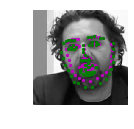

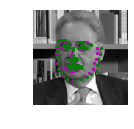

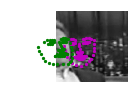

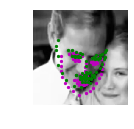

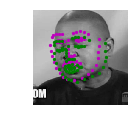

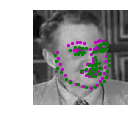

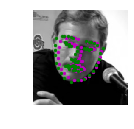

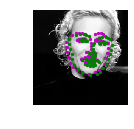

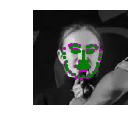

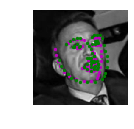

9.628412144692863 18.43399365986076


In [17]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:
from statistics import mean 
visualize_output(test_images, test_outputs, gt_pts)
x_axis = []
y_axis = []
for i in range(68):
    a= np.square(np.subtract(test_outputs[0][i].cpu().detach().numpy(), gt_pts[0][i].numpy()))
    x_axis.append(a[0])
    y_axis.append(a[1])
print(mean(x_axis)*1000, mean(y_axis)*1000)

Once you've found a good model (or two), save your model so you can load it and use it later!

In [ ]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_1.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: ***Loss Function: Mean Square Error,*** Since we are working on regression, Mean Square Error is the great choice to detect the difference between the two pixels.

   ***Optimizer: Adam,*** as it converges very fast and efficiently, it salso supports the problem of vanishing and exploding gradient and momentum helps to find the global minima.

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: I started with naimish-net(paper which was mentioned in the project) which has 4 convolutional layers along with 3 fullyconnected layers and used elu as activatiion function, I discovered that 4 layers were not performing good as the number of facial points were different, so I added one more convolutional layer which helped model to find the pattern in more efficient way. 

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: ***Number of Epochs:*** It is decided on the basis of average loss, as it starts converge, training of model gets stopped for further training.

***batch_size: *** size where the loss is minimum at the particular learning rate of the optimizer and number of epochs

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[-0.14128344 -0.2304031  -0.01192258  0.03916787 -0.19304293]
 [-0.1587081   0.0577576   0.06467982  0.11920634  0.04050139]
 [ 0.05721325 -0.16897933  0.10796136 -0.01808403 -0.07620637]
 [-0.061607   -0.10832778 -0.13528834 -0.19181225 -0.20648985]
 [ 0.08511048 -0.07418404 -0.10282275 -0.00181323  0.074822  ]]
(5, 5)


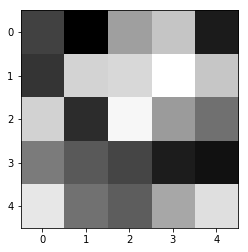

In [19]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.cpu().numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

In [ ]:
##TODO: load in and display any image from the transformed test dataset

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: (does it detect vertical lines or does it blur out noise, etc.) write your answer here

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!